In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

import numpy as np
np.random.seed(0)
import random
import json
import pandas as pd
from datetime import datetime, timedelta

import pickle
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder
import json

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs

from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score


# Day 3

In [20]:
df = pd.read_csv('C:/Users/Win11/Downloads/20240509_030938_45245_4dsx5.csv')
df_2 = pd.read_csv('C:/Users/Win11/Downloads/20240509_051907_83264_4dsx5.csv')
df = pd.concat([df, df_2], ignore_index = True)
df = df[df['matuirity_day'] == 2]

print(df.shape)
df.head(4)


(38611, 56)


,#account_id,register_time,matuirity_day,paying_matuirity,minutes_to_play,minutes_to_payment,minutes_to_pay_since_first_game,pay_matuirity,payments_to_date,payments_last_14d,...,win_amount_last_14d,win_amount_last_7d,win_money_rate_sequence,max_bet,past_disputer,new_disputer_30d,local_time_before_6,local_time_6_to_12,local_time_12_to_18,local_time_after_18
0,10207496,2024-01-02 00:33:46.000,2,2,0.0,3,3.0,2,2,2,...,16.39,16.39,"[0.57,null,null]",1.00,0,0,0.0,0.0,0.0,0.0
3,10208626,2024-01-02 03:05:04.000,2,2,0.0,4,4.0,2,3,3,...,35.07,35.07,"[0.49,null,null]",0.75,0,0,0.0,533.0,0.0,136.0
6,10208812,2024-01-02 03:27:23.000,2,2,0.0,26,26.0,2,2,2,...,16.80,16.80,"[0.67,null,null]",0.20,0,0,0.0,0.0,0.0,0.0
9,10209165,2024-01-02 04:13:48.000,2,2,0.0,4,4.0,2,5,5,...,137.15,137.15,"[0.25,0.36,0.3]",7.40,0,0,206.0,456.0,0.0,0.0


In [21]:
# REMOVE FEATURES AND DUMMIFY SEQUENCES 


def data_processing(df): 

    df['max_payment']           = df['max_payment']     / df['spent_to_date']
    df['max_daily_spent']       = df['max_daily_spent'] / df['spent_to_date']
    df['day_1_count_payment']   = (df['daily_payment_history_count'].apply(lambda x: x.replace('[', '').replace(']', '').split(',')[0])).astype(float)
    df['day_1_total_payment']   = (df['daily_spent_history_count'].apply(lambda x: x.replace('[', '').replace(']', '').split(',')[0])).astype(float)
    # df['d2_3_total_payment']    = (df['daily_spent_history_count'].apply(lambda x: x.replace('[', '').split(',')[1] + x.replace('[', '').split(',')[2])).astype(float)

    df['max_games_daily_games'] = df['max_games_daily_games'] / df['games_to_date']
    df['daily_games_first_1d']  = df['daily_games_first_1d']  / df['games_to_date']

    df['games_to_date']         = df['local_time_before_6'] + df['local_time_6_to_12'] + df['local_time_12_to_18'] + df['local_time_after_18'] 
    df['local_time_before_6']   = df['local_time_before_6'] / df['games_to_date']
    df['local_time_6_to_12']    = df['local_time_6_to_12']  / df['games_to_date']
    df['local_time_12_to_18']   = df['local_time_12_to_18'] / df['games_to_date']
    df['local_time_after_18']   = df['local_time_after_18'] / df['games_to_date']
    
    df['win_spent_ratio']       = df['win_amount_to_date']  / (df['spent_to_date']+0.0001)
    
    # Retention 
    df['full_[retention]']      = df['retention_sequence'].apply(lambda x: x[-2])
    df['full_pay_[retention]']  = df['daily_payment_history_binary'].apply(lambda x: x[-2])

    return df 
df = data_processing(df)

# Base Cols
cols = [
        # 'paying_matuirity', 'spent_to_date', 'spent_last_14d',  'spent_last_7d', 'max_daily_spent'
        'paying_matuirity', 'spent_to_date','max_daily_spent'
        
        # , 'max_payment', 'payments_last_14d', 'payments_last_7d',  'payments_to_date',  'minutes_to_payment', 'minutes_to_pay_since_first_game'
        , 'max_payment', 'payments_to_date',  'minutes_to_payment', 'minutes_to_pay_since_first_game'
        
        # , 'games_last_14d', 'games_last_7d', 'games_to_date', 'max_games_daily_games', 'daily_games_first_14d', 'daily_games_first_7d', 'daily_games_first_1d', 'minutes_to_play'
        , 'games_to_date', 'max_games_daily_games', 'daily_games_first_1d', 'minutes_to_play'
        
        # , 'money_games_to_date', 'bet_money_to_date', 'max_bet',  'money_games_last_14d', 'money_games_last_7d'
        , 'money_games_to_date', 'bet_money_to_date', 'max_bet'

        # , 'win_amount_to_date',  'win_amount_last_14d', 'win_amount_last_7d'
        , 'win_amount_to_date'
        
        , 'minutes_to_withdraw_since_first_payment', 'withdrawn_attempted_ammount_to_date', 'withdrawn_attempt_to_date'
        
        , 'local_time_before_6', 'local_time_6_to_12', 'local_time_12_to_18', 'local_time_after_18'
        ]
columns_of_interest = ['retention_sequence', 'days_betting_money_sequence', 'days_50_usd_bet_money_sequence', 'daily_payment_history_binary']  # Add additional columns here if needed
def truncate_list(lst):
    return lst[-14:]
for column in columns_of_interest:
    df[column] = df[column].apply(truncate_list)

# II. Execute the dummification
columns_info = {'retention_sequence': 'playing_days_'
                # , 'money_bet_sequence': 'money_bet_'
                , 'daily_payment_history_binary': 'payer_'
                # , 'daily_payment_history_count': 'pay_'
                , 'days_betting_money_sequence': 'days_bet_'
                , 'days_50_usd_bet_money_sequence': 'days_gt50_bet_'
                # , 'province': 'province_'
                }  # Add additional columns and identifiers here if needed

dummy_variable_list = []  # List to store dummy variables generated for each column

for column, identifier in columns_info.items():
    # Calculate sum of 'new_disputer_30d' for each unique value in the column
    sum_disputer = df.groupby(column)['new_disputer_30d'].sum()
    # Filter unique values where sum is >= 12
    valid_values = sum_disputer[sum_disputer >= 15].index.tolist()
    # Generate dummy variables for valid values
    dummy_variables = pd.get_dummies(df[column].loc[df[column].isin(valid_values)], prefix=identifier).astype(int)
    dummy_variable_list.append(dummy_variables)
    df = pd.concat([df, dummy_variables], axis=1)

# Concatenate all dummy variables into a single DataFrame
final_dummy_variables = pd.concat(dummy_variable_list, axis=1)
cols = cols + list(final_dummy_variables.columns)

# III. Can remove extra items
items_to_remove = ['working_hours_bets_to_date', 'minutes_to_withdraw_since_first_payment', 'withdrawn_attempted_ammount_to_date', 'withdrawn_attempt_to_date', 'province']
cols = [item for item in cols if item not in items_to_remove]
final_dummy_variables.columns


Index(['playing_days__[1,0,0]', 'playing_days__[1,0,1]',
       'playing_days__[1,1,0]', 'playing_days__[1,1,1]', 'payer__[1,0,0]',
       'payer__[1,0,1]', 'payer__[1,1,0]', 'payer__[1,1,1]',
       'days_bet__[1,0,0]', 'days_bet__[1,0,1]', 'days_bet__[1,1,0]',
       'days_bet__[1,1,1]', 'days_gt50_bet__[0,0,0]', 'days_gt50_bet__[1,0,0]',
       'days_gt50_bet__[1,0,1]', 'days_gt50_bet__[1,1,0]',
       'days_gt50_bet__[1,1,1]'],
      dtype='object')

In [22]:
df = df[df['day_1_total_payment'] < 500]

In [23]:
# GENERATE THE QUANTILES

num_cols = [
            'spent_to_date', 'max_daily_spent', 'max_payment', 'payments_to_date', 'minutes_to_payment', 'minutes_to_pay_since_first_game', 
            'games_to_date', 'max_games_daily_games', 'daily_games_first_1d', 'minutes_to_play', 'money_games_to_date', 'bet_money_to_date', 'max_bet',
            'local_time_before_6', 'local_time_6_to_12', 'local_time_12_to_18', 'local_time_after_18',
            'win_spent_ratio', 'day_1_count_payment', 'day_1_total_payment'
            ]

def quantile_binning(df, columns, num_quantiles):

    # Get the qauntile for each column. 

    bins_dict = {}
    quantile_columns = {}
    
    for column in columns:
        # Calculate quantile bins
        quantile_labels, quantile_bins = pd.qcut(df[column], num_quantiles, retbins=True, duplicates='drop')
        
        # Remove duplicate values from bin edges
        quantile_bins = sorted(set(quantile_bins))
        
        # Apply binning to the column
        new_column_name = f"{column}_quantile"
        df[new_column_name] = pd.cut(df[column], bins=quantile_bins, labels=quantile_bins[:-1], include_lowest=True).astype(float)
        
        # Store the bins for each column
        bins_dict[column] = quantile_bins
        
        # Store the quantile column names
        quantile_columns[column] = new_column_name
    
    return df, bins_dict, quantile_columns

def quantile_dummies(df, column, quantile_bins):

    # Create dummy variables for each quantile
    for i in range(1, len(quantile_bins)):
        n = round(quantile_bins[i], 3)
        dummy_name = f"{column}_gt_{n}_true"
        df[dummy_name] = (df[column] > quantile_bins[i-1]).astype(int)

    return df

def quantile_dummies_all(df, num_cols, quantile_columns):

    for column in num_cols:
        quantile_column = quantile_columns.get(column)
        if quantile_column:
            quantile_bins = sorted(set(df[quantile_column]))
            quantile_bins = [x for x in quantile_bins if pd.notna(x)]
            df = quantile_dummies(df, column, quantile_bins)
    
    return df

df, bins_dict, quantile_columns = quantile_binning(df, num_cols, num_quantiles = 10)
df = quantile_dummies_all(df, num_cols, quantile_columns)

# Subset the columns
sequence_cols = [col for col in df.columns if col.endswith(']')]
quantile_col_ok = [col[:-5] for col in df.columns if col.endswith('_true')]
df.columns = [col[:-5] if col.endswith('_true') else col for col in df.columns]

cols_2 = list(quantile_col_ok) + list(sequence_cols)
cols_2


['spent_to_date_gt_4.0',
 'spent_to_date_gt_5.0',
 'spent_to_date_gt_10.0',
 'spent_to_date_gt_18.0',
 'spent_to_date_gt_23.0',
 'spent_to_date_gt_40.0',
 'spent_to_date_gt_89.0',
 'max_daily_spent_gt_0.6',
 'max_daily_spent_gt_0.8',
 'max_payment_gt_0.278',
 'max_payment_gt_0.4',
 'max_payment_gt_0.5',
 'max_payment_gt_0.625',
 'max_payment_gt_0.83',
 'payments_to_date_gt_2.0',
 'payments_to_date_gt_3.0',
 'payments_to_date_gt_4.0',
 'payments_to_date_gt_6.0',
 'minutes_to_payment_gt_1.0',
 'minutes_to_payment_gt_2.0',
 'minutes_to_payment_gt_4.0',
 'minutes_to_payment_gt_6.0',
 'minutes_to_payment_gt_11.0',
 'minutes_to_payment_gt_31.0',
 'minutes_to_payment_gt_414.2',
 'minutes_to_payment_gt_1476.0',
 'minutes_to_pay_since_first_game_gt_1.0',
 'minutes_to_pay_since_first_game_gt_2.0',
 'minutes_to_pay_since_first_game_gt_3.0',
 'minutes_to_pay_since_first_game_gt_5.0',
 'minutes_to_pay_since_first_game_gt_8.0',
 'minutes_to_pay_since_first_game_gt_21.0',
 'minutes_to_pay_since_first

### Univariate rules

In [24]:
# Calculate 
grouped_dfs = []
for col in cols_2: 
    grouped = df.groupby(col)['new_disputer_30d'].agg(['sum', 'count', 'mean']).reset_index()
    grouped = grouped.rename(columns={grouped.columns[0]: 'C_1'})
    grouped['C_1'] = grouped['C_1'].apply(lambda x: col + '_' + str(int(x)))
    grouped_dfs.append(grouped)

final_df = pd.concat(grouped_dfs)
final_df.insert(1, 'C_2', np.nan)
final_df.insert(2, 'C_3', np.nan)
final_df['C_1'] = final_df['C_1'].str.replace('_true_', '_')
final_df.reset_index(drop = True, inplace = True)


In [25]:
print(final_df.shape)
final_df.sort_values(by = 'mean', ascending = False).head(10)

(278, 6)


,C_1,C_2,C_3,sum,count,mean
18,max_payment_gt_0.278_0,NaN,NaN,1,1,1.000000
70,games_to_date_gt_1052.0_0,NaN,NaN,3,162,0.018519
259,"payer__[1,1,1]_1",NaN,NaN,46,2820,0.016312
20,max_payment_gt_0.4_0,NaN,NaN,59,3844,0.015349
96,max_games_daily_games_gt_0.687_0,NaN,NaN,2,135,0.014815
141,bet_money_to_date_gt_330.4_1,NaN,NaN,56,3830,0.014621
153,max_bet_gt_0.2_1,NaN,NaN,34,2394,0.014202
35,payments_to_date_gt_6.0_1,NaN,NaN,83,5934,0.013987
85,games_to_date_gt_332.0_1,NaN,NaN,52,3830,0.013577
277,"days_gt50_bet__[1,1,1]_1",NaN,NaN,49,3612,0.013566


### n = 2 combinations

In [26]:
# Keep only columns usable for double combinations
selected_cases = final_df[final_df['sum'] >= 12]
relevants = list(set(list(selected_cases['C_1'].str.replace(r'_\d+$', '', regex=True))))
print(len(relevants))
# relevants


139


In [27]:
import itertools
combis = list(itertools.combinations(relevants, 2))

# Extract the substrings before '_gt_' pattern from each tuple
prefixes = [[item.split('_gt_')[0] for item in pair] for pair in combis]

# Find the unique prefixes
unique_prefixes = set(prefixes[0])

# Initialize a list to store the filtered data
column_combinations = []

# Iterate over the data
for pair in combis:
    prefix1, prefix2 = [item.split('_gt_')[0] for item in pair]
    # Check if the prefixes are different
    if prefix1 != prefix2 or prefix1 not in unique_prefixes:
        column_combinations.append(pair)

column_combinations

[('days_gt50_bet__[1,0,1]', 'max_games_daily_games_gt_0.79'),
 ('days_gt50_bet__[1,0,1]', 'full_pay_[retention]'),
 ('days_gt50_bet__[1,0,1]', 'games_to_date_gt_482.0'),
 ('days_gt50_bet__[1,0,1]', 'day_1_total_payment_gt_5.0'),
 ('days_gt50_bet__[1,0,1]', 'max_bet_gt_0.5'),
 ('days_gt50_bet__[1,0,1]', 'max_bet_gt_1.5'),
 ('days_gt50_bet__[1,0,1]', 'max_payment_gt_0.278'),
 ('days_gt50_bet__[1,0,1]', 'bet_money_to_date_gt_330.4'),
 ('days_gt50_bet__[1,0,1]', 'minutes_to_payment_gt_31.0'),
 ('days_gt50_bet__[1,0,1]', 'local_time_6_to_12_gt_0.025'),
 ('days_gt50_bet__[1,0,1]', 'day_1_total_payment_gt_50.0'),
 ('days_gt50_bet__[1,0,1]', 'spent_to_date_gt_4.0'),
 ('days_gt50_bet__[1,0,1]', 'max_payment_gt_0.4'),
 ('days_gt50_bet__[1,0,1]', 'spent_to_date_gt_18.0'),
 ('days_gt50_bet__[1,0,1]', 'local_time_before_6_gt_0.366'),
 ('days_gt50_bet__[1,0,1]', 'days_bet__[1,1,1]'),
 ('days_gt50_bet__[1,0,1]', 'minutes_to_payment_gt_2.0'),
 ('days_gt50_bet__[1,0,1]', 'day_1_total_payment_gt_4.0'),


In [29]:
# Initialize an empty list to store filtered DataFrames
filtered_dfs = []

# Iterate over each combination
for combination in tqdm(column_combinations):
    # Group by the current combination of columns
    grouped = df.groupby(list(combination))['new_disputer_30d'].agg(['sum', 'count', 'mean']).reset_index()
    # Apply the filter condition
    filtered_grouped = grouped[(grouped['sum'] >= 10)]
    # Append the filtered DataFrame to the list
    filtered_dfs.append(filtered_grouped)

# Concatenate the filtered DataFrames
result_df = pd.concat(filtered_dfs)
result_df


100%|██████████| 9576/9576 [00:45<00:00, 209.28it/s]


,"days_gt50_bet__[1,0,1]",max_games_daily_games_gt_0.79,sum,count,mean,full_pay_[retention],games_to_date_gt_482.0,day_1_total_payment_gt_5.0,max_bet_gt_0.5,max_bet_gt_1.5,...,"payer__[1,0,1]",money_games_to_date_gt_94.0,minutes_to_payment_gt_6.0,money_games_to_date_gt_789.0,win_spent_ratio_gt_1.364,day_1_count_payment_gt_2.0,max_bet_gt_2.0,max_games_daily_games_gt_0.597,day_1_total_payment_gt_25.0,max_daily_spent_gt_0.8
0,0.0,0.0,74,8840,0.008371,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,80,23850,0.003354,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0.0,11,1072,0.010261,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.0,NaN,100,28519,0.003506,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,54,4171,0.012947,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,NaN,NaN,126,32005,0.003937,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
0,NaN,NaN,17,2193,0.007752,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,NaN,NaN,102,27643,0.003690,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
2,NaN,NaN,26,1677,0.015504,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0


In [30]:

# result_df.columns = [col[:-5] if col.endswith('_true') else col for col in result_df.columns]

def compact_dataframe(df):
    """
    Compact the DataFrame by keeping only two non-empty columns along with 'sum', 'count', and 'mean' columns.
    
    Parameters:
        df (DataFrame): The original DataFrame.
        
    Returns:
        DataFrame: The compacted DataFrame with two non-empty columns and 'sum', 'count', 'mean' columns.
    """
    # Initialize lists to store values for compacted DataFrame
    col1_values = []
    col2_values = []
    sum_values = []
    count_values = []
    mean_values = []
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Find the two non-empty columns (excluding 'sum', 'count', and 'mean')
        non_empty_columns = [col for col in row.index if col not in ['sum', 'count', 'mean'] and pd.notnull(row[col])]
        # Ensure that at least two non-empty columns are found
  
        if len(non_empty_columns) >= 2:
            # Add values to respective lists
            col1_values.append(non_empty_columns[0] + '_' + str(row[non_empty_columns[0]]))
            col2_values.append(non_empty_columns[1] + '_' + str(row[non_empty_columns[1]]))
            sum_values.append(row['sum'])
            count_values.append(row['count'])
            mean_values.append(row['mean'])
    
    # Create compacted DataFrame
    compacted_df = pd.DataFrame({'Column_1': col1_values ,
                                  'Column_2': col2_values,
                                  'sum': sum_values,
                                  'count': count_values,
                                  'mean': mean_values})
    
    return compacted_df

# Example usage:
compacted_df = compact_dataframe(result_df)
compacted_df.sort_values(by = 'mean', ascending = False).head(10)

,Column_1,Column_2,sum,count,mean
28424,win_spent_ratio_gt_4.207_0.0,money_games_to_date_gt_489.0_1.0,10,298,0.033557
12210,games_to_date_gt_332.0_1.0,max_bet_gt_0.2_1.0,19,636,0.029874
18114,max_bet_gt_0.2_1.0,"payer__[1,1,1]_1.0",17,590,0.028814
28390,win_spent_ratio_gt_4.207_0.0,"days_gt50_bet__[1,1,1]_1.0",18,663,0.027149
1009,full_pay_[retention]_1,max_bet_gt_0.2_1.0,24,899,0.026696
5715,max_payment_gt_0.4_0.0,day_1_count_payment_gt_2.0_0.0,12,450,0.026667
18292,max_bet_gt_0.2_1.0,"days_gt50_bet__[1,1,1]_1.0",19,713,0.026648
27816,win_spent_ratio_gt_6.063_0.0,money_games_to_date_gt_489.0_1.0,17,662,0.025680
27783,win_spent_ratio_gt_6.063_0.0,"days_gt50_bet__[1,1,1]_1.0",29,1131,0.025641
5621,max_payment_gt_0.4_0.0,day_1_total_payment_gt_10.0_0.0,13,507,0.025641


### n = 3

In [31]:
import itertools

column_combinations = list(itertools.combinations(cols_2, 3))
filtered_dfs = []

for combination in tqdm(column_combinations):
    # Group by the current combination of columns
    grouped = df.groupby(list(combination))['new_disputer_30d'].agg(['sum', 'count', 'mean']).reset_index()
    # print(grouped)
    # Apply the filter condition
    filtered_grouped = grouped[(grouped['sum'] >= 15) & (grouped['count'] >= 30)]
    # Append the filtered DataFrame to the list
    filtered_dfs.append(filtered_grouped)

result_df = pd.concat(filtered_dfs)
# result_df.columns = [col[:-5] if col.endswith('_true') else col for col in result_df.columns]

def compact_dataframe(df):

    col1_values = []
    col2_values = []
    col3_values = []
    sum_values = []
    count_values = []
    mean_values = []
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Find the two non-empty columns (excluding 'sum', 'count', and 'mean')
        non_empty_columns = [col for col in row.index if col not in ['sum', 'count', 'mean'] and pd.notnull(row[col])]
        # Ensure that at least two non-empty columns are found
  
        if len(non_empty_columns) >= 2:
            # Add values to respective lists
            col1_values.append(non_empty_columns[0] + '_' + str(row[non_empty_columns[0]]))
            col2_values.append(non_empty_columns[1] + '_' + str(row[non_empty_columns[1]]))
            col3_values.append(non_empty_columns[2] + '_' + str(row[non_empty_columns[2]]))
            sum_values.append(row['sum'])
            count_values.append(row['count'])
            mean_values.append(row['mean'])
    
    # Create compacted DataFrame
    compacted_df = pd.DataFrame({'C_1': col1_values ,
                                  'C_2': col2_values,
                                  'C_3': col3_values,
                                  'sum': sum_values,
                                  'count': count_values,
                                  'mean': mean_values})
    
    return compacted_df

compacted_df = compact_dataframe(result_df)
compacted_df


 25%|██▌       | 111134/437989 [10:18<36:21, 149.86it/s] 

# Day 7

In [266]:
df['daily_spent_history_count']
df[df['day_1_total_payment'] > 0][['daily_spent_history_count', 'd2_4_total_payment_rel']].max()

# import matplotlib.pyplot as plt

# # Assuming df is your DataFrame
# plt.figure(figsize=(10, 6))
# plt.hist(df['d4_7_total_payment_rel'], bins=30, color='skyblue', edgecolor='black')
# plt.title('Distribution of d4_7_total_payment_rel')
# plt.xlabel('d4_7_total_payment_rel')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

# import matplotlib.pyplot as plt

# # Assuming df is your DataFrame
# plt.figure(figsize=(8, 6))
# plt.boxplot(df['d4_7_total_payment_rel'])
# plt.title('Boxplot of d4_7_total_payment_rel')
# plt.ylabel('d4_7_total_payment_rel')
# plt.show()


df.loc[df['day_1_total_payment'] > 0, 'd4_7_total_payment_rel'] = df.loc[df['day_1_total_payment'] > 0, 'd4_7_total_payment_rel'].clip(upper=max_value)


KeyError: 'daily_spent_history_count'

In [267]:
df[['day_1_total_payment', 'd2_4_total_payment_rel', 'd4_7_total_payment_rel', 'daily_spent_history_count']]

KeyError: "None of [Index(['day_1_total_payment', 'd2_4_total_payment_rel',\n       'd4_7_total_payment_rel', 'daily_spent_history_count'],\n      dtype='object')] are in the [columns]"

In [4]:
# REMOVE FEATURES AND DUMMIFY SEQUENCES 

df = pd.read_csv('C:/Users/Win11/Downloads/20240509_030938_45245_4dsx5.csv')
df_2 = pd.read_csv('C:/Users/Win11/Downloads/20240509_051907_83264_4dsx5.csv')
df = pd.concat([df, df_2], ignore_index = True)
# df = pd.read_csv('C:/Users/Win11/Downloads/20240510_053033_89002_663cp.csv')
df = pd.read_csv('C:/Users/Win11/Downloads/20240510_062631_03308_663cp.csv')
df = df[df['matuirity_day'] == 6]

print(df.shape)
df.head(4)

def data_processing(df): 

    df['max_payment']               = df['max_payment']     / df['spent_to_date']
    df['max_daily_spent']           = df['max_daily_spent'] / df['spent_to_date']
    df['day_1_count_payment']       = (df['daily_payment_history_count'].apply(lambda x: x.replace('[', '').replace(']', '').split(',')[0])).astype(float)
    df['day_1_total_payment']       = (df['daily_spent_history_count'].apply(lambda x: x.replace('[', '').replace(']', '').split(',')[0])).astype(float)

    df = df[df['day_1_total_payment'] > 0]

    df['d2_4_total_payment_rel']    = (df['daily_spent_history_count'].apply(lambda x: float(x.replace('[', '').split(',')[1]) + float(x.replace('[', '').split(',')[2]) + float(x.replace('[', '').split(',')[3]))).astype(float)
    df['d4_7_total_payment_rel']    = (df['daily_spent_history_count'].apply(lambda x: float(x.replace('[', '').split(',')[4]) + float(x.replace('[', '').split(',')[5]) + float(x.replace('[', '').replace(']', '').split(',')[6]))).astype(float)
    df = df[df['d2_4_total_payment_rel'] > 0]

    df['d4_7_total_payment_rel']    = df['d4_7_total_payment_rel'] / (df['d2_4_total_payment_rel'])
    df['d2_4_total_payment_rel']    = df['d2_4_total_payment_rel'] / (df['day_1_total_payment'])
    # max_value = df[df['day_1_total_payment'] > 0]['d2_4_total_payment_rel'].max()
    # df.loc[df['day_1_total_payment'] > 0, 'd4_7_total_payment_rel'] = df.loc[df['day_1_total_payment'] > 0, 'd4_7_total_payment_rel'].clip(upper = max_value)

    df['max_games_daily_games'] = df['max_games_daily_games'] / df['games_to_date']
    df['daily_games_first_1d']  = df['daily_games_first_1d']  / df['games_to_date']

    df['games_to_date']         = df['local_time_before_6'] + df['local_time_6_to_12'] + df['local_time_12_to_18'] + df['local_time_after_18'] 
    df['local_time_before_6']   = df['local_time_before_6'] / df['games_to_date']
    df['local_time_6_to_12']    = df['local_time_6_to_12']  / df['games_to_date']
    df['local_time_12_to_18']   = df['local_time_12_to_18'] / df['games_to_date']
    df['local_time_after_18']   = df['local_time_after_18'] / df['games_to_date']
    
    df['win_spent_ratio']       = df['win_amount_to_date']  / (df['spent_to_date']+0.0001)
    
    # Retention 
    df['full_[retention]']      = df['retention_sequence'].apply(lambda x: x[-2])
    df['full_pay_[retention]']  = df['daily_payment_history_binary'].apply(lambda x: x[-2])

    return df
df = data_processing(df)

# Base Cols
cols = [
        # 'paying_matuirity', 'spent_to_date', 'spent_last_14d',  'spent_last_7d', 'max_daily_spent'
        'paying_matuirity', 'spent_to_date','max_daily_spent'
        
        # , 'max_payment', 'payments_last_14d', 'payments_last_7d',  'payments_to_date',  'minutes_to_payment', 'minutes_to_pay_since_first_game'
        , 'max_payment', 'payments_to_date',  'minutes_to_payment', 'minutes_to_pay_since_first_game'
        
        # , 'games_last_14d', 'games_last_7d', 'games_to_date', 'max_games_daily_games', 'daily_games_first_14d', 'daily_games_first_7d', 'daily_games_first_1d', 'minutes_to_play'
        , 'games_to_date', 'max_games_daily_games', 'daily_games_first_1d', 'minutes_to_play'
        
        # , 'money_games_to_date', 'bet_money_to_date', 'max_bet',  'money_games_last_14d', 'money_games_last_7d'
        , 'money_games_to_date', 'bet_money_to_date', 'max_bet'

        # , 'win_amount_to_date',  'win_amount_last_14d', 'win_amount_last_7d'
        , 'win_amount_to_date'
        
        , 'minutes_to_withdraw_since_first_payment', 'withdrawn_attempted_ammount_to_date', 'withdrawn_attempt_to_date'
        
        , 'local_time_before_6', 'local_time_6_to_12', 'local_time_12_to_18', 'local_time_after_18'
        ]
columns_of_interest = ['retention_sequence', 'days_betting_money_sequence', 'days_50_usd_bet_money_sequence', 'daily_payment_history_binary']  # Add additional columns here if needed
def truncate_list(lst):
    return lst[-14:]
for column in columns_of_interest:
    df[column] = df[column].apply(truncate_list)

# II. Execute the dummification
columns_info = {'retention_sequence': 'playing_days_'
                # , 'money_bet_sequence': 'money_bet_'
                , 'daily_payment_history_binary': 'payer_'
                # , 'daily_payment_history_count': 'pay_'
                , 'days_betting_money_sequence': 'days_bet_'
                , 'days_50_usd_bet_money_sequence': 'days_gt50_bet_'
                # , 'province': 'province_'
                }  # Add additional columns and identifiers here if needed

dummy_variable_list = []  # List to store dummy variables generated for each column

for column, identifier in columns_info.items():
    # Calculate sum of 'new_disputer_30d' for each unique value in the column
    sum_disputer = df.groupby(column)['new_disputer_30d'].sum()
    # Filter unique values where sum is >= 12
    valid_values = sum_disputer[sum_disputer >= 15].index.tolist()
    # Generate dummy variables for valid values
    dummy_variables = pd.get_dummies(df[column].loc[df[column].isin(valid_values)], prefix=identifier).astype(int)
    dummy_variable_list.append(dummy_variables)
    df = pd.concat([df, dummy_variables], axis=1)

# Concatenate all dummy variables into a single DataFrame
final_dummy_variables = pd.concat(dummy_variable_list, axis=1)
cols = cols + list(final_dummy_variables.columns)

# III. Can remove extra items
items_to_remove = ['working_hours_bets_to_date', 'minutes_to_withdraw_since_first_payment', 'withdrawn_attempted_ammount_to_date', 'withdrawn_attempt_to_date', 'province']
cols = [item for item in cols if item not in items_to_remove]
final_dummy_variables.columns

# df = df[df['day_1_total_payment'] < 500]

(34098, 56)


KeyboardInterrupt: 

In [99]:
# New bersion code only 

# df = pd.read_csv('C:/Users/Win11/Downloads/20240509_030938_45245_4dsx5.csv')
# df_2 = pd.read_csv('C:/Users/Win11/Downloads/20240509_051907_83264_4dsx5.csv')
# df = pd.concat([df, df_2], ignore_index = True)
# "C:\Users\Win11\Downloads\20240528_122231_00006_d3vzr.csv"
# "C:\Users\Win11\Downloads\.csv"
# df = pd.read_csv("C:/Users/Win11/Downloads/20240528_122231_00006_d3vzr.csv")
# df = pd.read_csv("C:/Users/Win11/Downloads/20240530_033447_45015_yi672.csv")
# df = pd.read_csv("C:/Users/Win11/Downloads/20240530_081837_02124_ji794.csv")
# df = pd.read_csv("C:/Users/Win11/Downloads/20240603_052412_78673_x22mn.csv")
df = pd.read_csv("C:/Users/Win11/Downloads/20240603_072923_85886_x22mn.csv")

print(df.shape)
df.head(4)

df.columns[2:]

# df = df[df['monetary_consumption_score'] >= 450]
print(df.shape)
df.columns

(79052, 18)
(79052, 18)


Index(['#account_id', 'disputes_d30', 'disputed_d30', 'game_types',
       'long_sessions_ps_score_150', 'long_sessions_ps_score_180',
       'long_sessions_ps_score_210', 'long_sessions_ps_score_240',
       'monetary_consumption_score', 'user_withdrawed', 'fluctuating_wagers',
       'payment_methods_score', 'payment_impulsiveness_score', 'nightly_play',
       'days_played_score', 'increasing_tolerance', 'losses_of_winning_score',
       'time_comsumption'],
      dtype='object')

In [6]:
# disputed ammount is the sum of the 
disputed_amount = df['disputed_d30'].sum()
disputed_amount

276176.13738

In [100]:
num_cols = [
            # 'spent_to_date', 'max_daily_spent', 'max_payment', 'payments_to_date', 'minutes_to_payment', 'minutes_to_pay_since_first_game', 
            # 'games_to_date', 'max_games_daily_games', 'daily_games_first_1d', 'minutes_to_play', 'money_games_to_date', 'bet_money_to_date', 'max_bet',
            # 'local_time_before_6', 'local_time_6_to_12', 'local_time_12_to_18', 'local_time_after_18',
            # 'win_spent_ratio', 'day_1_count_payment', 'day_1_total_payment'
            'd2_4_total_payment_rel'
            # , 'd4_7_total_payment_rel'
            , 'day_1_total_payment'
            ]

num_cols = [
            'monetary_consumption_score',
            'game_types', 
            # 'binge_gaming', 
            # 'long_sessions_score_2', 
            # 'long_sessions_ps_score_150',
            # 'long_sessions_ps_score_180',
            # , 'long_sessions_ps_score_210'
            # 'long_sessions_ps_score_240',
            # 'user_withdrawed', 
            # 'fluctuating_wagers', 
            # 'payment_methods_score',
            # 'payment_impulsiveness_score', 
            # 'nightly_play', 
            # 'days_played_score',
            # 'increasing_tolerance', 
            # 'losses_of_winning_score', 
            # 'time_comsumption'
            ]

df['new_disputer_30d'] = df['disputes_d30'].apply(lambda x: 1 if x > 0 else 0)
print(df['new_disputer_30d'].mean())

# Top columns 
# Base columns 

def quantile_binning(df, columns, num_quantiles):

    # Get the qauntile for each column. 

    bins_dict = {}
    quantile_columns = {}
    
    for column in columns:
        # Calculate quantile bins
        quantile_labels, quantile_bins = pd.qcut(df[column], num_quantiles, retbins=True, duplicates='drop')
        
        # Remove duplicate values from bin edges
        quantile_bins = sorted(set(quantile_bins))
        
        # Apply binning to the column
        new_column_name = f"{column}_quantile"
        df[new_column_name] = pd.cut(df[column], bins=quantile_bins, labels=quantile_bins[:-1], include_lowest=True).astype(float)
        
        # Store the bins for each column
        bins_dict[column] = quantile_bins
        
        # Store the quantile column names
        quantile_columns[column] = new_column_name
    
    return df, bins_dict, quantile_columns

def quantile_dummies(df, column, quantile_bins):

    # Create dummy variables for each quantile
    for i in range(1, len(quantile_bins)):
        n = round(quantile_bins[i], 3)
        dummy_name = f"{column}_gt_{n}_true"
        df[dummy_name] = (df[column] > quantile_bins[i-1]).astype(int)

    return df

def quantile_dummies_all(df, num_cols, quantile_columns):

    for column in num_cols:
        quantile_column = quantile_columns.get(column)
        if quantile_column:
            quantile_bins = sorted(set(df[quantile_column]))
            quantile_bins = [x for x in quantile_bins if pd.notna(x)]
            df = quantile_dummies(df, column, quantile_bins)
    
    return df

# df, bins_dict, quantile_columns = quantile_binning(df, num_cols, num_quantiles = 130)
df, bins_dict, quantile_columns = quantile_binning(df, num_cols, num_quantiles = 60)
df = quantile_dummies_all(df, num_cols, quantile_columns)


0.009398876688761828


In [101]:
sequence_cols = [col for col in df.columns if col.endswith(']')]
quantile_col_ok = [col[:-5] for col in df.columns if col.endswith('_true')]
df.columns = [col[:-5] if col.endswith('_true') else col for col in df.columns]

# # Function to check if group by combination has sum >= 10
# def is_valid_group(df, combination):
#     grouped_sum = df.groupby(list(combination))['new_disputer_30d'].sum()
#     return (grouped_sum >= 10).any()

# # Find valid columns
# valid_columns = []
# for col in relevants:
#     if is_valid_group(df, [col]):
#         valid_columns.append(col)

# # Select only valid columns
# df = df[valid_columns + ['new_disputer_30d']]
# df

In [102]:
# cols_2 = list(quantile_col_ok) + list(sequence_cols)
# cols_2 = list(quantile_col_ok) #+ list(sequence_cols)
cols_2 = list(quantile_col_ok) + ['user_withdrawed']
cols_2

['monetary_consumption_score_gt_0.66',
 'monetary_consumption_score_gt_0.842',
 'monetary_consumption_score_gt_1.61',
 'monetary_consumption_score_gt_1.784',
 'monetary_consumption_score_gt_2.57',
 'monetary_consumption_score_gt_2.726',
 'monetary_consumption_score_gt_3.52',
 'monetary_consumption_score_gt_3.668',
 'monetary_consumption_score_gt_4.48',
 'monetary_consumption_score_gt_4.51',
 'monetary_consumption_score_gt_4.61',
 'monetary_consumption_score_gt_5.14',
 'monetary_consumption_score_gt_6.294',
 'monetary_consumption_score_gt_7.05',
 'monetary_consumption_score_gt_7.978',
 'monetary_consumption_score_gt_9.21',
 'monetary_consumption_score_gt_9.26',
 'monetary_consumption_score_gt_9.32',
 'monetary_consumption_score_gt_9.92',
 'monetary_consumption_score_gt_11.104',
 'monetary_consumption_score_gt_12.046',
 'monetary_consumption_score_gt_13.74',
 'monetary_consumption_score_gt_13.97',
 'monetary_consumption_score_gt_15.714',
 'monetary_consumption_score_gt_18.264',
 'monetar

In [103]:
grouped_dfs = []
for col in cols_2: 
    grouped_1 = df.groupby(col)['new_disputer_30d'].agg(['sum', 'count', 'mean']).reset_index()
    grouped_2 = df.groupby(col)['disputed_d30'].agg(['sum']).reset_index()
    grouped_2.rename(columns={'sum': 'amount'}, inplace=True)
    grouped = pd.merge(grouped_1, grouped_2, on=col)
    grouped = grouped.rename(columns={grouped.columns[0]: 'C_1'})
    grouped['C_1'] = grouped['C_1'].apply(lambda x: col + '_' + str(int(x)))
    grouped_dfs.append(grouped)

final_df = pd.concat(grouped_dfs)
final_df.insert(1, 'C_2', np.nan)
final_df.insert(2, 'C_3', np.nan)
final_df['C_1'] = final_df['C_1'].str.replace('_true_', '_')
final_df.reset_index(drop = True, inplace = True)

print(final_df.shape)
final_df['amount_per'] = (final_df['amount'] / disputed_amount).apply(lambda x: str(round(x*100, 2)) + '%')
final_df['amount'] = final_df['amount']
final_df[final_df['sum'] >= 10].sort_values(by = 'mean', ascending = False).head(60)
# 用户， 他们会 x50 - 5000%

(156, 7)


,C_1,C_2,C_3,sum,count,mean,amount,amount_per
95,monetary_consumption_score_gt_591.657_1,NaN,NaN,144,2636,0.054628,214967.96500,77.84%
93,monetary_consumption_score_gt_325.752_1,NaN,NaN,182,3949,0.046088,229737.66758,83.19%
91,monetary_consumption_score_gt_225.48_1,NaN,NaN,217,5271,0.041169,235686.05558,85.34%
89,monetary_consumption_score_gt_168.697_1,NaN,NaN,250,6586,0.037959,245072.81958,88.74%
87,monetary_consumption_score_gt_132.04_1,NaN,NaN,275,7903,0.034797,248235.27558,89.88%
85,monetary_consumption_score_gt_107.73_1,NaN,NaN,309,9212,0.033543,252759.40990,91.52%
83,monetary_consumption_score_gt_93.6_1,NaN,NaN,335,10541,0.031781,256337.24648,92.82%
81,monetary_consumption_score_gt_77.949_1,NaN,NaN,359,11833,0.030339,259966.98848,94.13%
79,monetary_consumption_score_gt_66.32_1,NaN,NaN,374,13176,0.028385,260815.88906,94.44%
77,monetary_consumption_score_gt_57.074_1,NaN,NaN,387,14493,0.026703,261357.62364,94.63%


In [104]:
payment = final_df[final_df['C_1'].str.contains('monetary_consumption')].sort_values(by='C_1', ascending=False)
# final_df = final_df[~final_df['C_1'].str.contains('monetary_consumption')].sort_values(by='C_1', ascending=False)


In [105]:
final_df['mean'].mean()*1.1
final_df.tail()

,C_1,C_2,C_3,sum,count,mean,amount,amount_per
151,game_types_gt_36.0_1,NaN,NaN,75,3917,0.019147,15785.27632,5.72%
152,game_types_gt_44.0_0,NaN,NaN,697,76418,0.009121,264956.61964,95.94%
153,game_types_gt_44.0_1,NaN,NaN,46,2634,0.017464,11219.51774,4.06%
154,user_withdrawed_0,NaN,NaN,483,65811,0.007339,82237.37922,29.78%
155,user_withdrawed_1,NaN,NaN,260,13241,0.019636,193938.75816,70.22%


# doub

In [107]:
selected_cases   = final_df[final_df['sum'] >= 20][final_df['mean'] >= (final_df['mean'].mean())*1.11] # You can apply another filter (Ideally you say below 150 cases)
selected_cases   = final_df[final_df['sum'] >= 500]#[final_df['mean'] >= (final_df['mean'].mean())*1.05] # You can apply another filter (Ideally you say below 150 cases)
selected_cases_3 = final_df[final_df['sum'] >= 2][final_df['mean'] >= 0.00048]
relevants = list(set(list(selected_cases['C_1'].str.replace(r'_\d+$', '', regex=True))))
relevants_3 = list(set(list(selected_cases_3['C_1'].str.replace(r'_\d+$', '', regex=True))))
print(len(relevants))
print(len(relevants_3))
relevants 

50
78


['monetary_consumption_score_gt_21.04',
 'game_types_gt_44.0',
 'monetary_consumption_score_gt_18.82',
 'game_types_gt_2.0',
 'monetary_consumption_score_gt_4.48',
 'monetary_consumption_score_gt_1.784',
 'monetary_consumption_score_gt_225.48',
 'game_types_gt_3.0',
 'game_types_gt_26.0',
 'monetary_consumption_score_gt_4.61',
 'game_types_gt_36.0',
 'game_types_gt_30.0',
 'monetary_consumption_score_gt_7.05',
 'monetary_consumption_score_gt_15.714',
 'monetary_consumption_score_gt_18.74',
 'monetary_consumption_score_gt_9.92',
 'monetary_consumption_score_gt_2.726',
 'monetary_consumption_score_gt_3.668',
 'game_types_gt_27.0',
 'game_types_gt_32.0',
 'monetary_consumption_score_gt_2.57',
 'monetary_consumption_score_gt_9.26',
 'game_types_gt_20.0',
 'monetary_consumption_score_gt_11.104',
 'monetary_consumption_score_gt_325.752',
 'monetary_consumption_score_gt_5.14',
 'monetary_consumption_score_gt_6.294',
 'game_types_gt_6.0',
 'game_types_gt_4.0',
 'monetary_consumption_score_gt_0

In [109]:
import itertools
combis = list(itertools.combinations(relevants, 2))

# Extract the substrings before '_gt_' pattern from each tuple
prefixes = [[item.split('_gt_')[0] for item in pair] for pair in combis]

# Find the unique prefixes
unique_prefixes = set(prefixes[0])

# Initialize a list to store the filtered data
column_combinations = []

# Iterate over the data
for pair in combis:
    prefix1, prefix2 = [item.split('_gt_')[0] for item in pair]
    # Check if the prefixes are different
    if prefix1 != prefix2 or prefix1 not in unique_prefixes:
        column_combinations.append(pair)

column_combinations


# Initialize an empty list to store filtered DataFrames
filtered_dfs = []

# Iterate over each combination
for combination in tqdm(column_combinations):
    # Group by the current combination of columns
    # grouped = df.groupby(list(combination))['new_disputer_30d'].agg(['sum', 'count', 'mean']).reset_index()
    grouped_1 = df.groupby(list(combination))['new_disputer_30d'].agg(['sum', 'count', 'mean']).reset_index()
    grouped_2 = df.groupby(list(combination))['disputed_d30'].agg(['sum']).reset_index()
    grouped_2.rename(columns={'sum': 'amount'}, inplace=True)
    grouped = pd.merge(grouped_1, grouped_2, on=combination)
    # print(grouped)
    # Apply the filter condition
    filtered_grouped = grouped[(grouped['sum'] >= 10)][(grouped['mean'] >= 0.06)]
    filtered_grouped = grouped[(grouped['sum'] >= 1)][(grouped['mean'] >= 0.00000006)]
    
    # Append the filtered DataFrame to the list
    if not filtered_grouped.empty:
        filtered_dfs.append(filtered_grouped)

# Concatenate the filtered DataFrames
result_df = pd.concat(filtered_dfs)
result_df['amount_per'] = (result_df['amount'] / disputed_amount).apply(lambda x: str(round(x*100, 2)) + '%')
result_df['amount'] = result_df['amount']

result_df


100%|██████████| 561/561 [00:10<00:00, 54.94it/s]


,monetary_consumption_score_gt_21.04,game_types_gt_44.0,sum,count,mean,amount,game_types_gt_2.0,game_types_gt_3.0,game_types_gt_26.0,game_types_gt_36.0,...,monetary_consumption_score_gt_3.52,monetary_consumption_score_gt_23.05,monetary_consumption_score_gt_591.657,monetary_consumption_score_gt_12.046,monetary_consumption_score_gt_18.64,monetary_consumption_score_gt_0.842,monetary_consumption_score_gt_13.74,monetary_consumption_score_gt_9.32,monetary_consumption_score_gt_1.61,amount_per
0,0.0,0.0,220,51058,0.004309,4416.27716,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6%
1,0.0,1.0,6,807,0.007435,287.49800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1%
2,1.0,0.0,477,25360,0.018809,260540.34248,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.34%
3,1.0,1.0,40,1827,0.021894,10932.01974,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.96%
0,0.0,NaN,32,6148,0.005205,367.23000,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,NaN,NaN,516,34224,0.015077,258042.39080,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,93.43%
0,NaN,NaN,9,2329,0.003864,136.90800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.05%
1,NaN,NaN,136,22963,0.005923,15568.40658,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.64%
2,NaN,NaN,6,3310,0.001813,9.87200,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0%


In [110]:

result_df.columns = [col[:-5] if col.endswith('_true') else col for col in result_df.columns]

def compact_dataframe(df):
    """
    Compact the DataFrame by keeping only two non-empty columns along with 'sum', 'count', and 'mean' columns.
    
    Parameters:
        df (DataFrame): The original DataFrame.
        
    Returns:
        DataFrame: The compacted DataFrame with two non-empty columns and 'sum', 'count', 'mean' columns.
    """
    # Initialize lists to store values for compacted DataFrame
    col1_values = []
    col2_values = []
    sum_values = []
    count_values = []
    mean_values = []
    amount_values = []
    amount_per_values = []
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Find the two non-empty columns (excluding 'sum', 'count', and 'mean')
        # non_empty_columns = [col for col in row.index if col not in ['sum', 'count', 'mean'] and pd.notnull(row[col])]
        non_empty_columns = [col for col in row.index if col not in ['sum', 'count', 'mean', 'amount', 'amount_per'] and pd.notnull(row[col])]
        # Ensure that at least two non-empty columns are found
  
        if len(non_empty_columns) >= 2:
            # Add values to respective lists
            col1_values.append(non_empty_columns[0] + '_' + str(row[non_empty_columns[0]]))
            col2_values.append(non_empty_columns[1] + '_' + str(row[non_empty_columns[1]]))
            sum_values.append(row['sum'])
            count_values.append(row['count'])
            mean_values.append(row['mean'])
            amount_values.append(row['amount'])
            amount_per_values.append(row['amount_per'])
    
    # Create compacted DataFrame
    compacted_df = pd.DataFrame({'Column_1': col1_values ,
                                  'Column_2': col2_values,
                                  'sum': sum_values,
                                  'count': count_values,
                                  'mean': mean_values, 
                                  'amount': amount_values,
                                  'amount_per': amount_per_values})
    return compacted_df

# Example usage:
compacted_df = compact_dataframe(result_df)
compacted_df[compacted_df['sum'] >= 10].sort_values(by = 'mean', ascending = False).head(10)

,Column_1,Column_2,sum,count,mean,amount,amount_per
2065,game_types_gt_5.0_0.0,monetary_consumption_score_gt_591.657_1.0,11,114,0.096491,9447.62800,3.42%
1705,game_types_gt_6.0_0.0,monetary_consumption_score_gt_591.657_1.0,13,161,0.080745,12114.68000,4.39%
1590,game_types_gt_4.0_0.0,monetary_consumption_score_gt_325.752_1.0,10,125,0.080000,3925.99800,1.42%
1940,game_types_gt_7.0_0.0,monetary_consumption_score_gt_591.657_1.0,17,215,0.079070,15330.26632,5.55%
1612,game_types_gt_5.0_0.0,monetary_consumption_score_gt_325.752_1.0,13,187,0.069519,9700.77800,3.51%
1529,game_types_gt_20.0_0.0,monetary_consumption_score_gt_591.657_1.0,76,1199,0.063386,93277.98864,33.77%
1884,game_types_gt_23.0_0.0,monetary_consumption_score_gt_591.657_1.0,87,1384,0.062861,118064.31064,42.75%
2036,game_types_gt_21.0_0.0,monetary_consumption_score_gt_591.657_1.0,80,1284,0.062305,95292.34064,34.5%
1389,game_types_gt_32.0_0.0,monetary_consumption_score_gt_591.657_1.0,124,1993,0.062218,204804.59384,74.16%
978,game_types_gt_30.0_0.0,monetary_consumption_score_gt_591.657_1.0,113,1823,0.061986,178850.04708,64.76%


In [58]:
compacted_df[compacted_df['sum'] >= 50].sort_values(by = 'mean', ascending = False).head(40)

,Column_1,Column_2,sum,count,mean,amount,amount_per
660,monetary_consumption_score_gt_752.825_1.0,game_types_gt_17.0_0.0,57,696,0.081897,70118.37832,25.39%
775,monetary_consumption_score_gt_752.825_1.0,game_types_gt_16.0_0.0,51,637,0.080063,62161.97832,22.51%
795,monetary_consumption_score_gt_752.825_1.0,game_types_gt_18.0_0.0,59,758,0.077836,75865.05832,27.47%
1060,monetary_consumption_score_gt_752.825_1.0,increasing_tolerance_gt_0.5_0.0,62,812,0.076355,90619.99488,32.81%
1068,monetary_consumption_score_gt_752.825_1.0,game_types_gt_19.0_0.0,62,819,0.075702,80631.00832,29.2%
1017,monetary_consumption_score_gt_752.825_1.0,game_types_gt_20.0_0.0,65,871,0.074627,87350.90064,31.63%
1058,monetary_consumption_score_gt_752.825_1.0,game_types_gt_22.0_0.0,74,1009,0.073340,108993.40664,39.47%
990,monetary_consumption_score_gt_752.825_1.0,game_types_gt_28.0_0.0,98,1340,0.073134,169454.32308,61.36%
1080,monetary_consumption_score_gt_752.825_1.0,game_types_gt_21.0_0.0,68,936,0.072650,89099.34664,32.26%
1062,monetary_consumption_score_gt_752.825_1.0,game_types_gt_32.0_0.0,106,1472,0.072011,194198.41468,70.32%


In [15]:
compacted_df[compacted_df['sum'] >= 10].sort_values(by = 'mean', ascending = False).head(60)

,Column_1,Column_2,sum,count,mean,amount,amount_per
896,payment_impulsiveness_score_gt_1.351_1.0,long_sessions_ps_score_240_gt_49.0_1.0,16,105,0.152381,74909.65920,27.12%
1019,payment_impulsiveness_score_gt_1.351_1.0,long_sessions_ps_score_180_gt_57.0_1.0,16,105,0.152381,74909.65920,27.12%
956,payment_impulsiveness_score_gt_1.351_1.0,long_sessions_ps_score_180_gt_51.0_1.0,16,110,0.145455,74909.65920,27.12%
572,payment_impulsiveness_score_gt_1.351_1.0,long_sessions_ps_score_180_gt_76.0_1.0,11,76,0.144737,64229.97320,23.26%
940,payment_impulsiveness_score_gt_1.351_1.0,long_sessions_ps_score_240_gt_56.0_1.0,13,91,0.142857,66789.05320,24.18%
1013,payment_impulsiveness_score_gt_1.351_1.0,long_sessions_ps_score_180_gt_65.0_1.0,13,92,0.141304,71919.37320,26.04%
296,monetary_consumption_score_gt_630.84_1.0,long_sessions_ps_score_180_gt_9.0_0.0,10,71,0.140845,6264.56000,2.27%
913,payment_impulsiveness_score_gt_1.351_1.0,long_sessions_ps_score_240_gt_44.0_1.0,16,114,0.140351,74909.65920,27.12%
325,monetary_consumption_score_gt_630.84_1.0,long_sessions_ps_score_180_gt_10.0_0.0,11,80,0.137500,10359.48000,3.75%
40,payment_impulsiveness_score_gt_1.351_1.0,long_sessions_ps_score_180_gt_47.0_1.0,16,119,0.134454,74909.65920,27.12%


In [25]:
compacted_df[compacted_df['sum'] >= 20].sort_values(by = 'mean', ascending = False).head(15)
compacted_df[compacted_df['Column_1'].str.contains('withdraw')].sort_values(by = 'mean', ascending = False).head(15)


,Column_1,Column_2,sum,count,mean,amount,amount_per


In [26]:
compacted_df.sort_values(by = 'mean', ascending = False).head(10)

,Column_1,Column_2,sum,count,mean,amount,amount_per
1015,payment_impulsiveness_score_gt_1.351_1.0,long_sessions_ps_score_180_gt_57.0_1.0,16,105,0.152381,74909.6592,27.12%
1045,payment_impulsiveness_score_gt_1.351_1.0,long_sessions_ps_score_240_gt_49.0_1.0,16,105,0.152381,74909.6592,27.12%
970,payment_impulsiveness_score_gt_1.351_1.0,long_sessions_ps_score_180_gt_51.0_1.0,16,110,0.145455,74909.6592,27.12%
530,payment_impulsiveness_score_gt_1.351_1.0,long_sessions_ps_score_180_gt_76.0_1.0,11,76,0.144737,64229.9732,23.26%
990,payment_impulsiveness_score_gt_1.351_1.0,long_sessions_ps_score_240_gt_56.0_1.0,13,91,0.142857,66789.0532,24.18%
129,payment_impulsiveness_score_gt_1.351_1.0,long_sessions_ps_score_180_gt_65.0_1.0,13,92,0.141304,71919.3732,26.04%
170,monetary_consumption_score_gt_630.84_1.0,long_sessions_ps_score_180_gt_9.0_0.0,10,71,0.140845,6264.5600,2.27%
935,payment_impulsiveness_score_gt_1.351_1.0,long_sessions_ps_score_240_gt_44.0_1.0,16,114,0.140351,74909.6592,27.12%
254,monetary_consumption_score_gt_630.84_1.0,long_sessions_ps_score_180_gt_10.0_0.0,11,80,0.137500,10359.4800,3.75%
1039,payment_impulsiveness_score_gt_1.351_1.0,long_sessions_ps_score_180_gt_47.0_1.0,16,119,0.134454,74909.6592,27.12%


In [27]:
def custom_sort_key(value):
    # Extract the first substring before the first '.'
    first_substring = re.match(r'^([^\.]+)\.', value).group(1)
    # Extract the digits from the substring
    digits = re.findall(r'\d+', first_substring)
    # Convert the digits to integers and return the first one
    return int(digits[0])

import re
compacted_df['rank'] = compacted_df['Column_1'].apply(custom_sort_key)
compacted_df

,Column_1,Column_2,sum,count,mean,amount,amount_per,rank
0,long_sessions_ps_score_180_gt_25.0_1.0,monetary_consumption_score_gt_630.84_1.0,100,1461,0.068446,184208.25384,66.7%,180
1,long_sessions_ps_score_180_gt_25.0_1.0,payment_impulsiveness_score_gt_1.351_1.0,22,188,0.117021,84799.73920,30.7%,180
2,long_sessions_ps_score_180_gt_25.0_1.0,payment_impulsiveness_score_gt_8.248_1.0,26,322,0.080745,86368.23920,31.27%,180
3,long_sessions_ps_score_180_gt_25.0_1.0,payment_impulsiveness_score_gt_42.944_1.0,38,604,0.062914,103114.83978,37.34%,180
4,long_sessions_ps_score_180_gt_25.0_1.0,monetary_consumption_score_gt_1114.575_1.0,79,1023,0.077224,158487.58584,57.39%,180
...,...,...,...,...,...,...,...,...
1916,monetary_consumption_score_gt_451.217_1.0,long_sessions_ps_score_240_gt_19.0_1.0,118,1958,0.060266,197195.34900,71.4%,451
1917,monetary_consumption_score_gt_451.217_1.0,long_sessions_ps_score_180_gt_37.0_1.0,93,1491,0.062374,165525.19152,59.93%,451
1918,monetary_consumption_score_gt_451.217_1.0,game_types_gt_41.0_0.0,133,2114,0.062914,209627.62984,75.9%,451
1919,monetary_consumption_score_gt_451.217_1.0,long_sessions_ps_score_180_gt_15.0_0.0,17,270,0.062963,12423.22400,4.5%,451


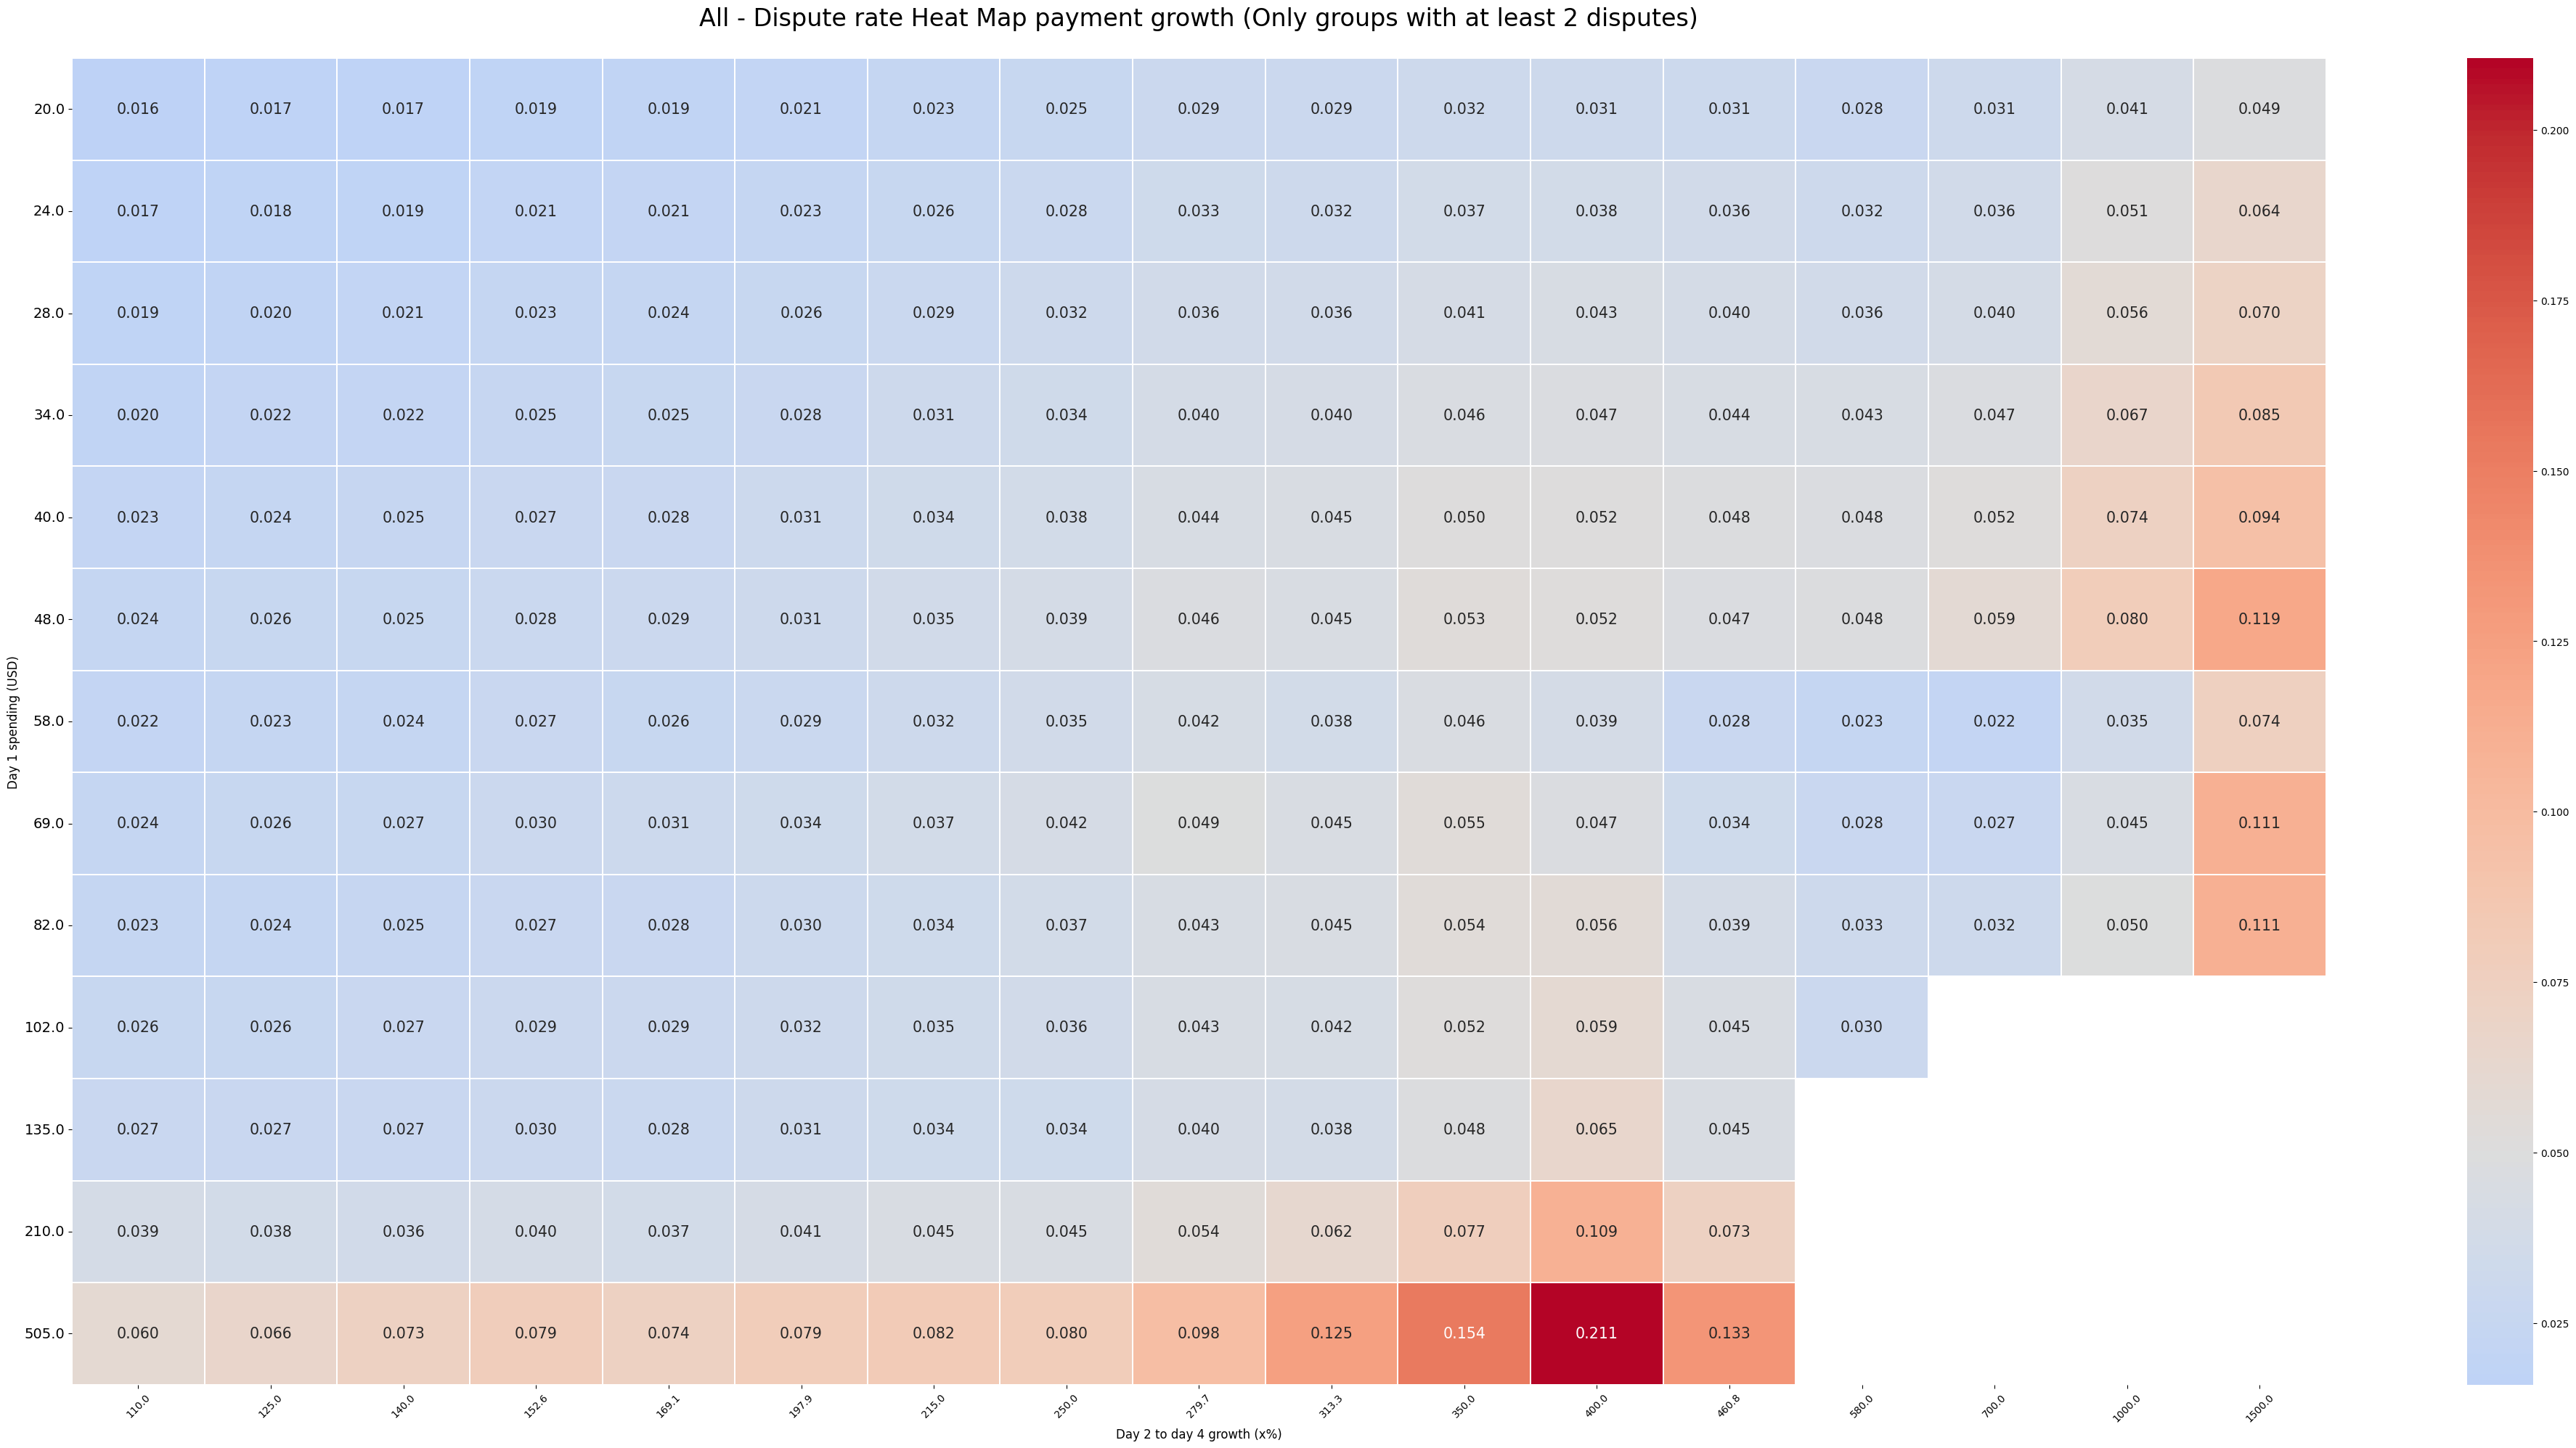

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame
# compacted_df['d5_7'] = (compacted_df['Column_1'].str.split('_').apply(lambda x: x[-2]).astype(float) * 100).apply(lambda x: round(x,1))
compacted_df['d5_7'] = (compacted_df['Column_1'].str.split('_').apply(lambda x: x[-2]).astype(float)).apply(lambda x: round(x,1))
compacted_df['d2_4'] = (compacted_df['Column_2'].str.split('_').apply(lambda x: x[-2]).astype(float) * 100).apply(lambda x: round(x,1))

compacted_df['d5_7'] = (compacted_df['Column_1'].str.split('_').apply(lambda x: x[-2]).astype(float)).apply(lambda x: round(x,1))
compacted_df['d2_4'] = (compacted_df['Column_2'].str.split('_').apply(lambda x: x[-2]).astype(float) * 100).apply(lambda x: round(x,1))

# Step 1: Sort unique values in the 'd5_7' column
unique_sorted_values = sorted(compacted_df['d5_7'].unique())

# Step 2: Select one value every three sequentially
selected_values = unique_sorted_values[::3]

# Step 3: Filter out selected values from the DataFrame
filtered_df = compacted_df[compacted_df['d5_7'].isin(selected_values)]

# Step 1: Sort unique values in the 'd5_7' column
unique_sorted_values = sorted(filtered_df['d2_4'].unique())

# Step 2: Select one value every three sequentially
selected_values = unique_sorted_values[::3]

# Step 3: Filter out selected values from the DataFrame
filtered_df = filtered_df[filtered_df['d2_4'].isin(selected_values)]


hola = filtered_df[filtered_df['Column_1'].str.startswith('day') & filtered_df['Column_1'].str.endswith('1.0') & filtered_df['Column_2'].str.endswith('1.0')].sort_values(by=['d5_7', 'd2_4'])
hola = hola[hola['d5_7'] >= 18][hola['d2_4'] >= 100]
hola
# # Pivot the DataFrame to create a correlation matrix
correlation_matrix = hola.pivot_table(index='d5_7', columns='d2_4', values='mean')

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(40, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".3f", linewidths=0.15, center=0.05, annot_kws={"fontsize": 14.8})
plt.title('All - Dispute rate Heat Map payment growth (Only groups with at least 2 disputes)', fontsize=24, y=1.02)
plt.yticks(rotation=0, fontsize=14)

plt.xlabel('Day 2 to day 4 growth (x%)', fontsize=12, y=1.01)
# plt.ylabel('Day 5 to day 7 growth (x%)')
plt.ylabel('Day 1 spending (USD)', fontsize=12, x=1.01)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


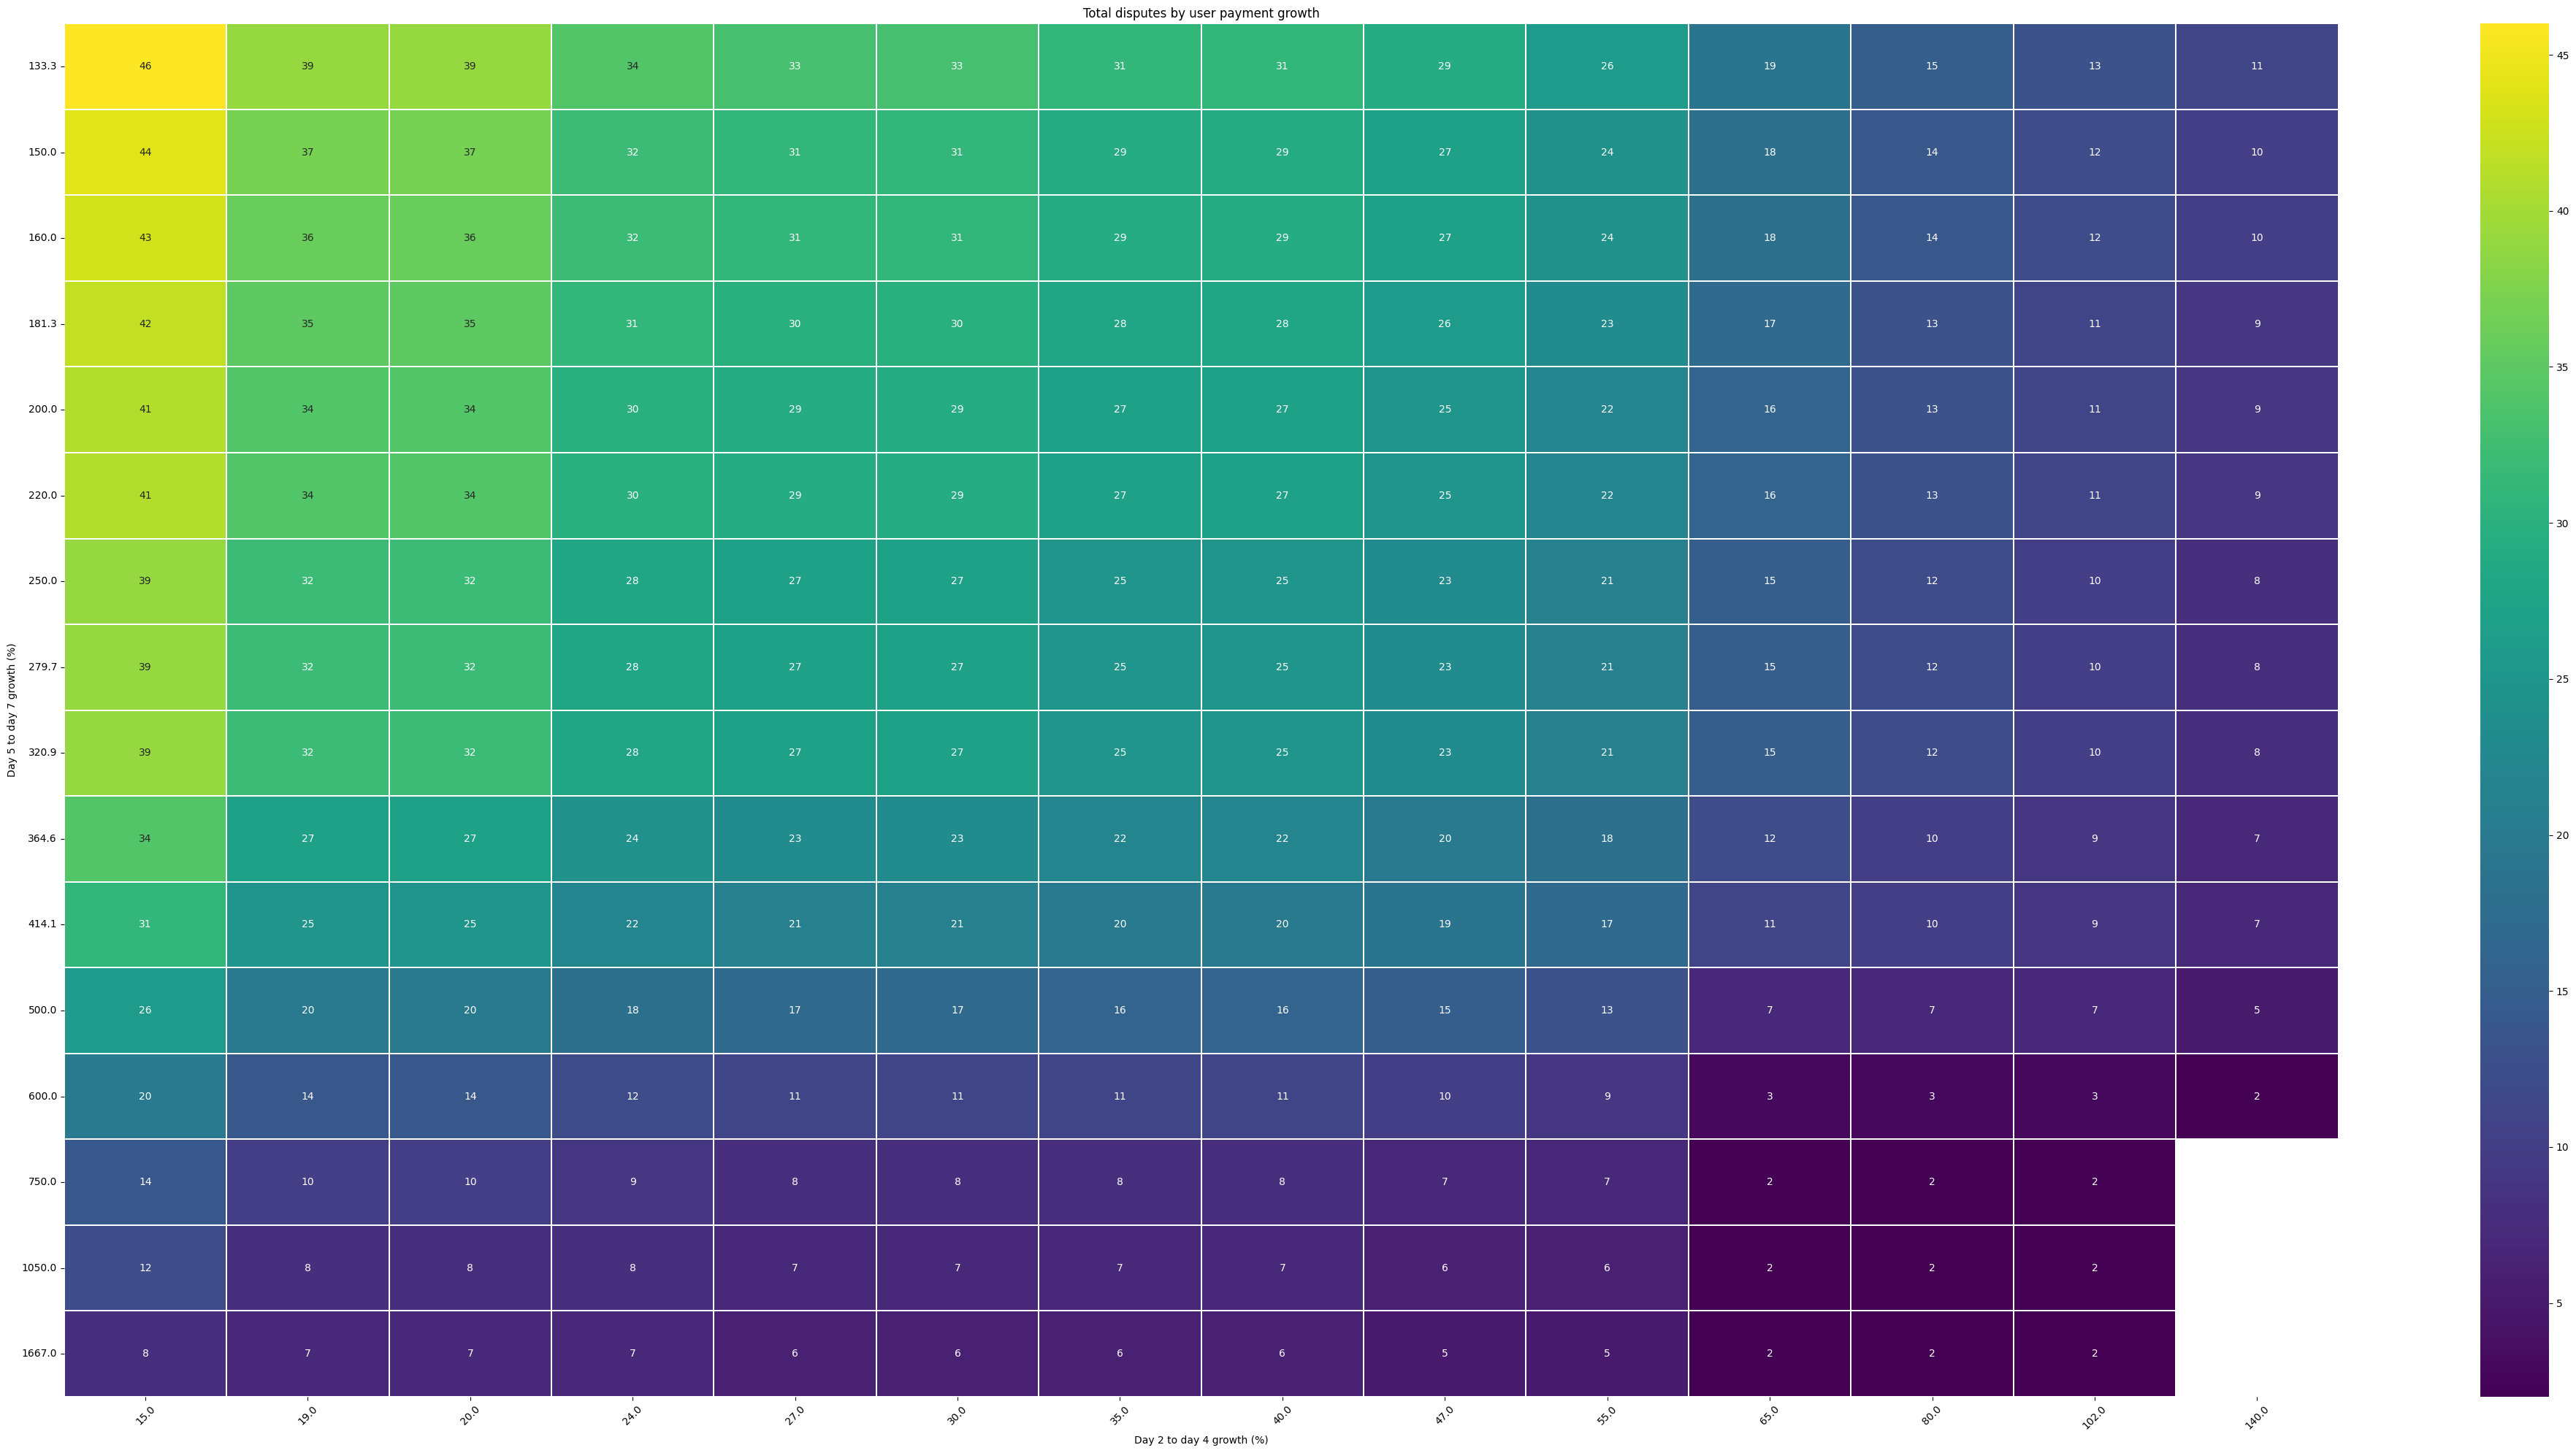

In [36]:


hola = compacted_df[compacted_df['Column_2'].str.startswith('day') & compacted_df['Column_1'].str.endswith('1.0') & compacted_df['Column_2'].str.endswith('1.0')].sort_values(by=['d5_7', 'd2_4'])
hola = hola[hola['d5_7'] >= 130][hola['d2_4'] >= 15]

# Pivot the DataFrame to create a correlation matrix
correlation_matrix = hola.pivot_table(index='d5_7', columns='d2_4', values='sum')

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(40, 20))
sns.heatmap(correlation_matrix, cmap='viridis', annot=True, fmt=".0f", linewidths=0.15)
plt.title('Total disputes by user payment growth')
plt.xlabel('Day 2 to day 4 growth (%)')
plt.ylabel('Day 5 to day 7 growth (%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


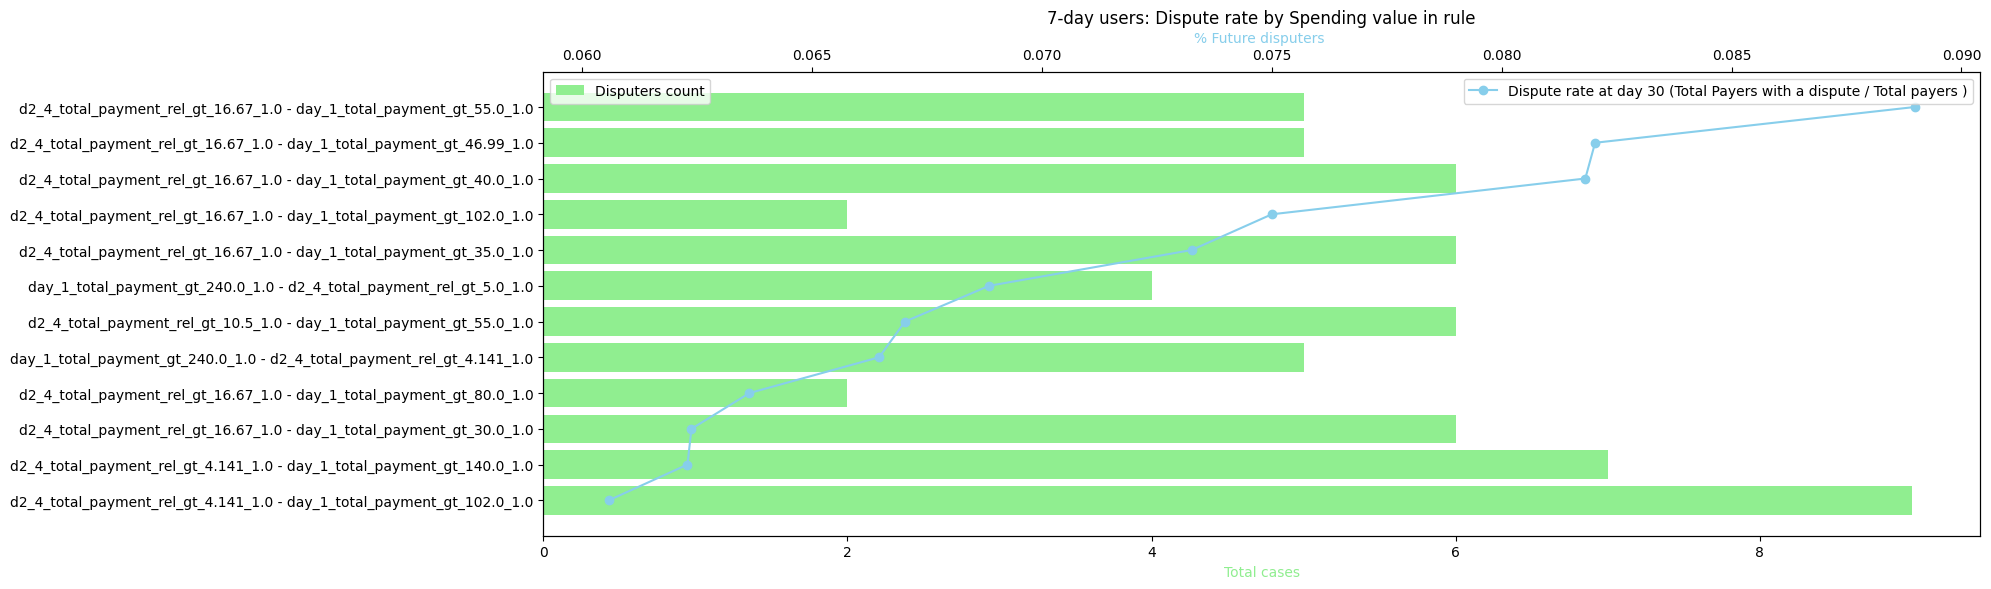

In [20]:
hola = compacted_df[compacted_df['Column_1'].str.endswith('_1.0')][compacted_df['Column_2'].str.endswith('_1.0')].sort_values(by = 'mean', ascending = False).head(12)
hola['C_1'] = hola['Column_1'] + ' - ' + compacted_df['Column_2']

hola['mean'] = hola['mean']*1.05
# hola = hola.sort_values(by = 'count', ascending = True).head(20)
# Plot C_1 against mean (line) and count (bar)
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot mean as a line
ax1.barh(hola['C_1'], hola['sum'], color='lightgreen', label='Disputers count')

# Create a secondary y-axis for count
ax2 = ax1.twiny()

# Plot count as a bar
ax2.plot(hola['mean'], hola['C_1'], color='skyblue', marker='o', label='Dispute rate at day 30 (Total Payers with a dispute / Total payers )')

# Set labels and titles
ax2.set_xlabel(f'% Future disputers ', color='skyblue')
ax1.set_xlabel('Total cases', color='lightgreen')
ax2.set_ylabel('Quantiles (0.5%)')
ax1.set_title('7-day users: Dispute rate by Spending value in rule')

# Invert y-axis to have higher values at the top
plt.gca().invert_yaxis()

# Add legend
ax2.legend(loc='upper right')
ax1.legend(loc='upper left')

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

### Game types analysis (Univariate)

In [37]:
game_types_analysis_df = final_df[final_df['C_1'].str.contains('.0_1', na=False)][final_df['C_1'].str.contains('type', na=False)].sort_values(by = 'count', ascending = True).head(60)
# game_types_analysis_df['C_1'] = game_types_analysis_df['C_1'].str.replace('game_types_gt_', '', regex=False)
# game_types_analysis_df['C_1'] = game_types_analysis_df['C_1'].str.replace('.0_1', '', regex=False)
game_types_analysis_df.sort_values(by = 'count', ascending = True).head(10)

,C_1,C_2,C_3,sum,count,mean,amount,amount_per
181,game_types_gt_48.0_1,NaN,NaN,33,1828,0.018053,9416.77174,3.41%
179,game_types_gt_40.0_1,NaN,NaN,55,2906,0.018926,12514.93174,4.53%
177,game_types_gt_35.0_1,NaN,NaN,75,3917,0.019147,15785.27632,5.72%
175,game_types_gt_32.0_1,NaN,NaN,90,4791,0.018785,20282.73432,7.34%
173,game_types_gt_30.0_1,NaN,NaN,105,5845,0.017964,38348.12992,13.89%
171,game_types_gt_28.0_1,NaN,NaN,111,6482,0.017124,47583.56108,17.23%
169,game_types_gt_27.0_1,NaN,NaN,124,7170,0.017294,58300.21908,21.11%
167,game_types_gt_26.0_1,NaN,NaN,156,8732,0.017865,64620.43508,23.4%
165,game_types_gt_24.0_1,NaN,NaN,169,9580,0.017641,105585.15952,38.23%
163,game_types_gt_23.0_1,NaN,NaN,187,10576,0.017682,114789.25210,41.56%


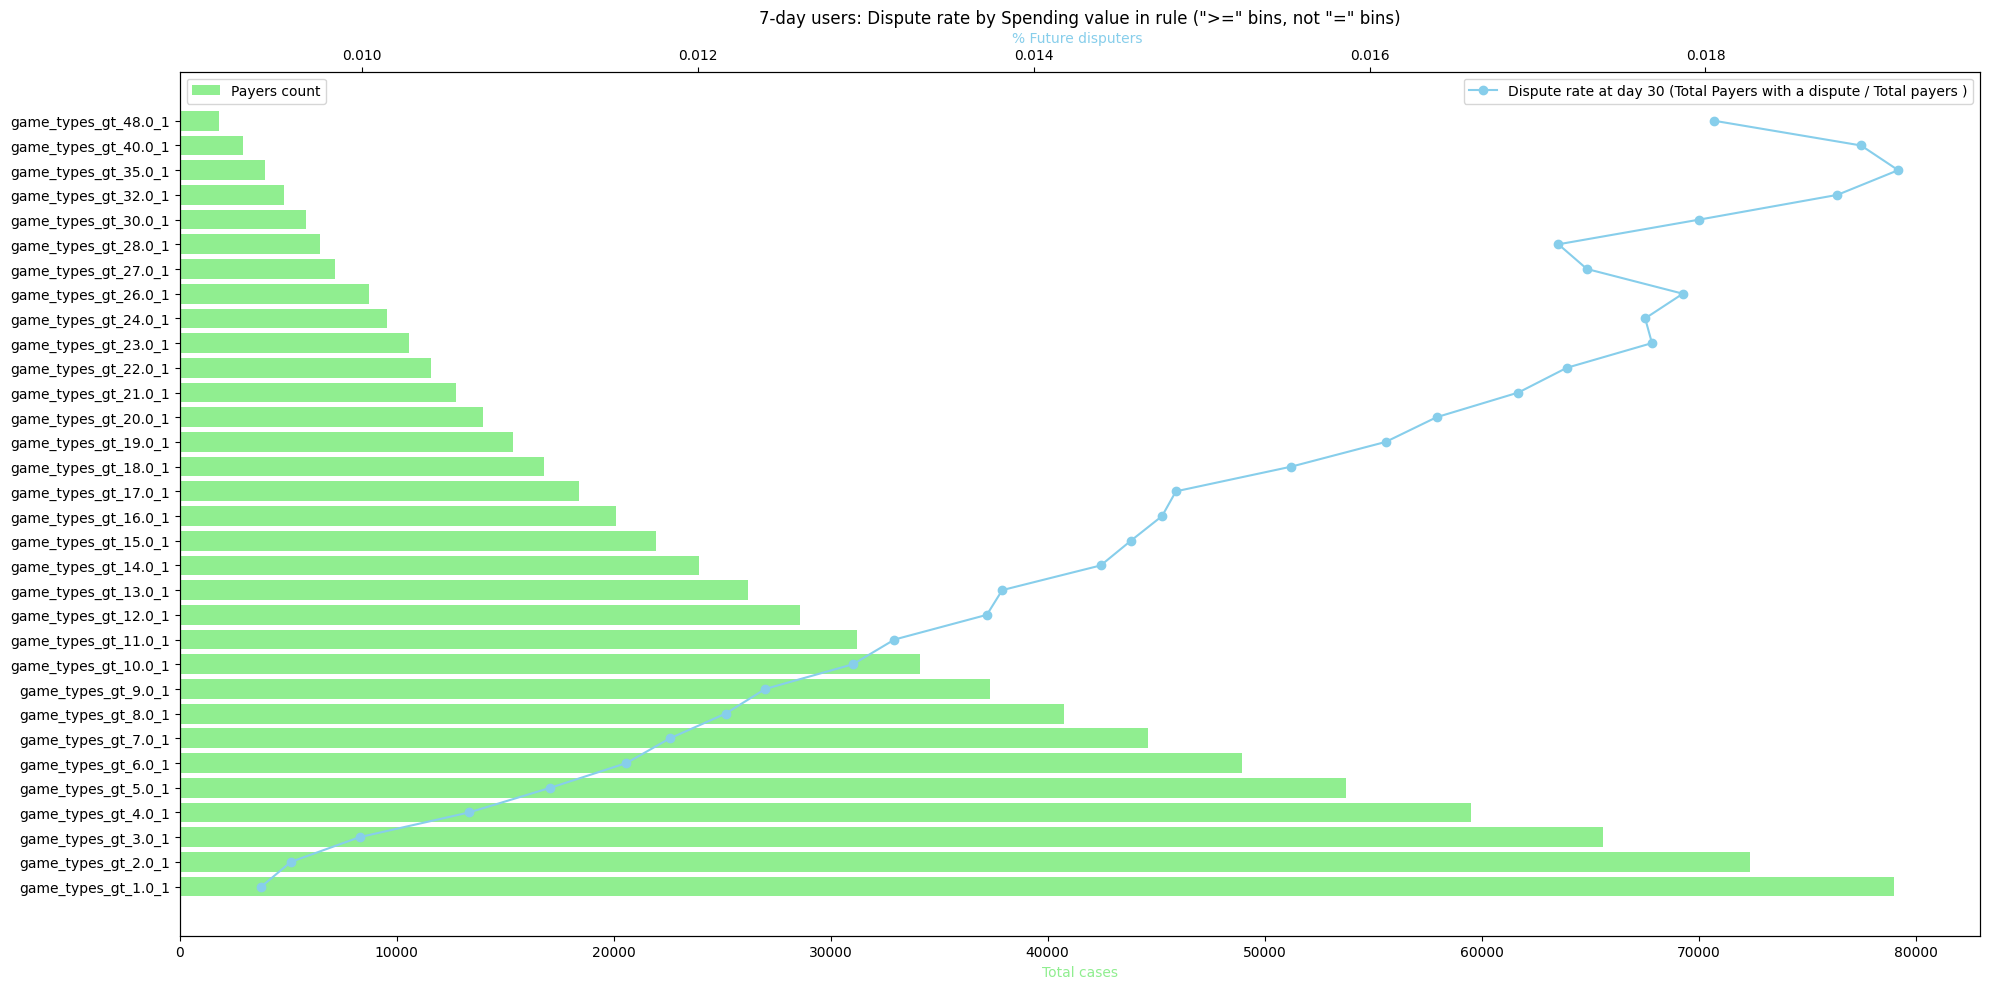

In [121]:
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot mean as a line
# ax1.barh(game_types_analysis_df['C_1'], game_types_analysis_df['sum'], color='lightgreen', label='Disputers count')
ax1.barh(game_types_analysis_df['C_1'], game_types_analysis_df['count'], color='lightgreen', label='Payers count')

# Create a secondary y-axis for count
ax2 = ax1.twiny()

# Plot count as a bar
ax2.plot(game_types_analysis_df['mean'], game_types_analysis_df['C_1'], color='skyblue', marker='o', label='Dispute rate at day 30 (Total Payers with a dispute / Total payers )')

# Set labels and titles
ax2.set_xlabel(f'% Future disputers ', color='skyblue')
ax1.set_xlabel('Total cases', color='lightgreen')
ax2.set_ylabel('Quantiles (0.5%)')
ax1.set_title('7-day users: Dispute rate by Spending value in rule (">=" bins, not "=" bins)')

# Invert y-axis to have higher values at the top
plt.gca().invert_yaxis()

# Add legend
ax2.legend(loc='upper right')
ax1.legend(loc='upper left')

# Adjust layout to prevent clipping of labels
plt.tight_layout()

In [94]:
compacted_df
hola = compacted_df[compacted_df['Column_1'].str.endswith('_1.0')][compacted_df['Column_2'].str.endswith('_1.0')].sort_values(by = 'mean', ascending = False)#.head(12)
hola = compacted_df.copy(deep = True)
hola['C_1'] = hola['Column_1'] + ' - ' + compacted_df['Column_2']

hola = hola[hola['C_1'].str.contains('mone', na=False)][hola['C_1'].str.contains('ga', na=False)]
hola
# hola.tail(50)

,Column_1,Column_2,sum,count,mean,amount,amount_per,C_1
500,monetary_consumption_score_gt_13.93_0.0,game_types_gt_26.0_0.0,158,41082,0.003846,2926.97000,1.06%,monetary_consumption_score_gt_13.93_0.0 - game...
501,monetary_consumption_score_gt_13.93_0.0,game_types_gt_26.0_1.0,11,2430,0.004527,462.12600,0.17%,monetary_consumption_score_gt_13.93_0.0 - game...
502,monetary_consumption_score_gt_13.93_1.0,game_types_gt_26.0_0.0,429,29238,0.014673,208628.73230,75.54%,monetary_consumption_score_gt_13.93_1.0 - game...
503,monetary_consumption_score_gt_13.93_1.0,game_types_gt_26.0_1.0,145,6302,0.023009,64158.30908,23.23%,monetary_consumption_score_gt_13.93_1.0 - game...
511,monetary_consumption_score_gt_13.93_0.0,game_types_gt_30.0_0.0,163,41981,0.003883,2981.25000,1.08%,monetary_consumption_score_gt_13.93_0.0 - game...
...,...,...,...,...,...,...,...,...
23012,game_types_gt_40.0_1.0,monetary_consumption_score_gt_18.64_0.0,6,838,0.007160,287.49800,0.1%,game_types_gt_40.0_1.0 - monetary_consumption_...
23013,game_types_gt_40.0_1.0,monetary_consumption_score_gt_18.64_1.0,49,2068,0.023694,12227.43374,4.43%,game_types_gt_40.0_1.0 - monetary_consumption_...
23014,game_types_gt_40.0_0.0,monetary_consumption_score_gt_6.394_0.0,92,28244,0.003257,973.78600,0.35%,game_types_gt_40.0_0.0 - monetary_consumption_...
23015,game_types_gt_40.0_0.0,monetary_consumption_score_gt_6.394_1.0,596,47902,0.012442,262687.41964,95.12%,game_types_gt_40.0_0.0 - monetary_consumption_...


In [116]:
hola = compacted_df[compacted_df['Column_1'].str.endswith('_1.0')][compacted_df['Column_2'].str.endswith('_0.0')].sort_values(by = 'mean', ascending = False)#.head(12)
hola = compacted_df.copy(deep = False)
hola['C_1'] = hola['Column_1'] + ' - ' + compacted_df['Column_2']
hola = hola[hola['C_1'].str.contains('mone', na=False)][hola['C_1'].str.contains('ga', na=False)]
# hola['mean'] = hola['mean']*1.05

# correlation_matrix
hola['Column_2'].unique()

array(['game_types_gt_44.0_0.0', 'game_types_gt_44.0_1.0',
       'game_types_gt_2.0_0.0', 'game_types_gt_2.0_1.0',
       'game_types_gt_3.0_0.0', 'game_types_gt_3.0_1.0',
       'game_types_gt_26.0_0.0', 'game_types_gt_26.0_1.0',
       'game_types_gt_36.0_0.0', 'game_types_gt_36.0_1.0',
       'game_types_gt_30.0_0.0', 'game_types_gt_30.0_1.0',
       'game_types_gt_27.0_0.0', 'game_types_gt_27.0_1.0',
       'game_types_gt_32.0_0.0', 'game_types_gt_32.0_1.0',
       'game_types_gt_20.0_0.0', 'game_types_gt_20.0_1.0',
       'game_types_gt_6.0_0.0', 'game_types_gt_6.0_1.0',
       'game_types_gt_4.0_0.0', 'game_types_gt_4.0_1.0',
       'game_types_gt_23.0_0.0', 'game_types_gt_23.0_1.0',
       'game_types_gt_7.0_0.0', 'game_types_gt_7.0_1.0',
       'game_types_gt_24.0_0.0', 'game_types_gt_24.0_1.0',
       'game_types_gt_21.0_0.0', 'game_types_gt_21.0_1.0',
       'game_types_gt_1.0_1.0', 'game_types_gt_5.0_0.0',
       'game_types_gt_5.0_1.0', 'monetary_consumption_score_gt_18.82

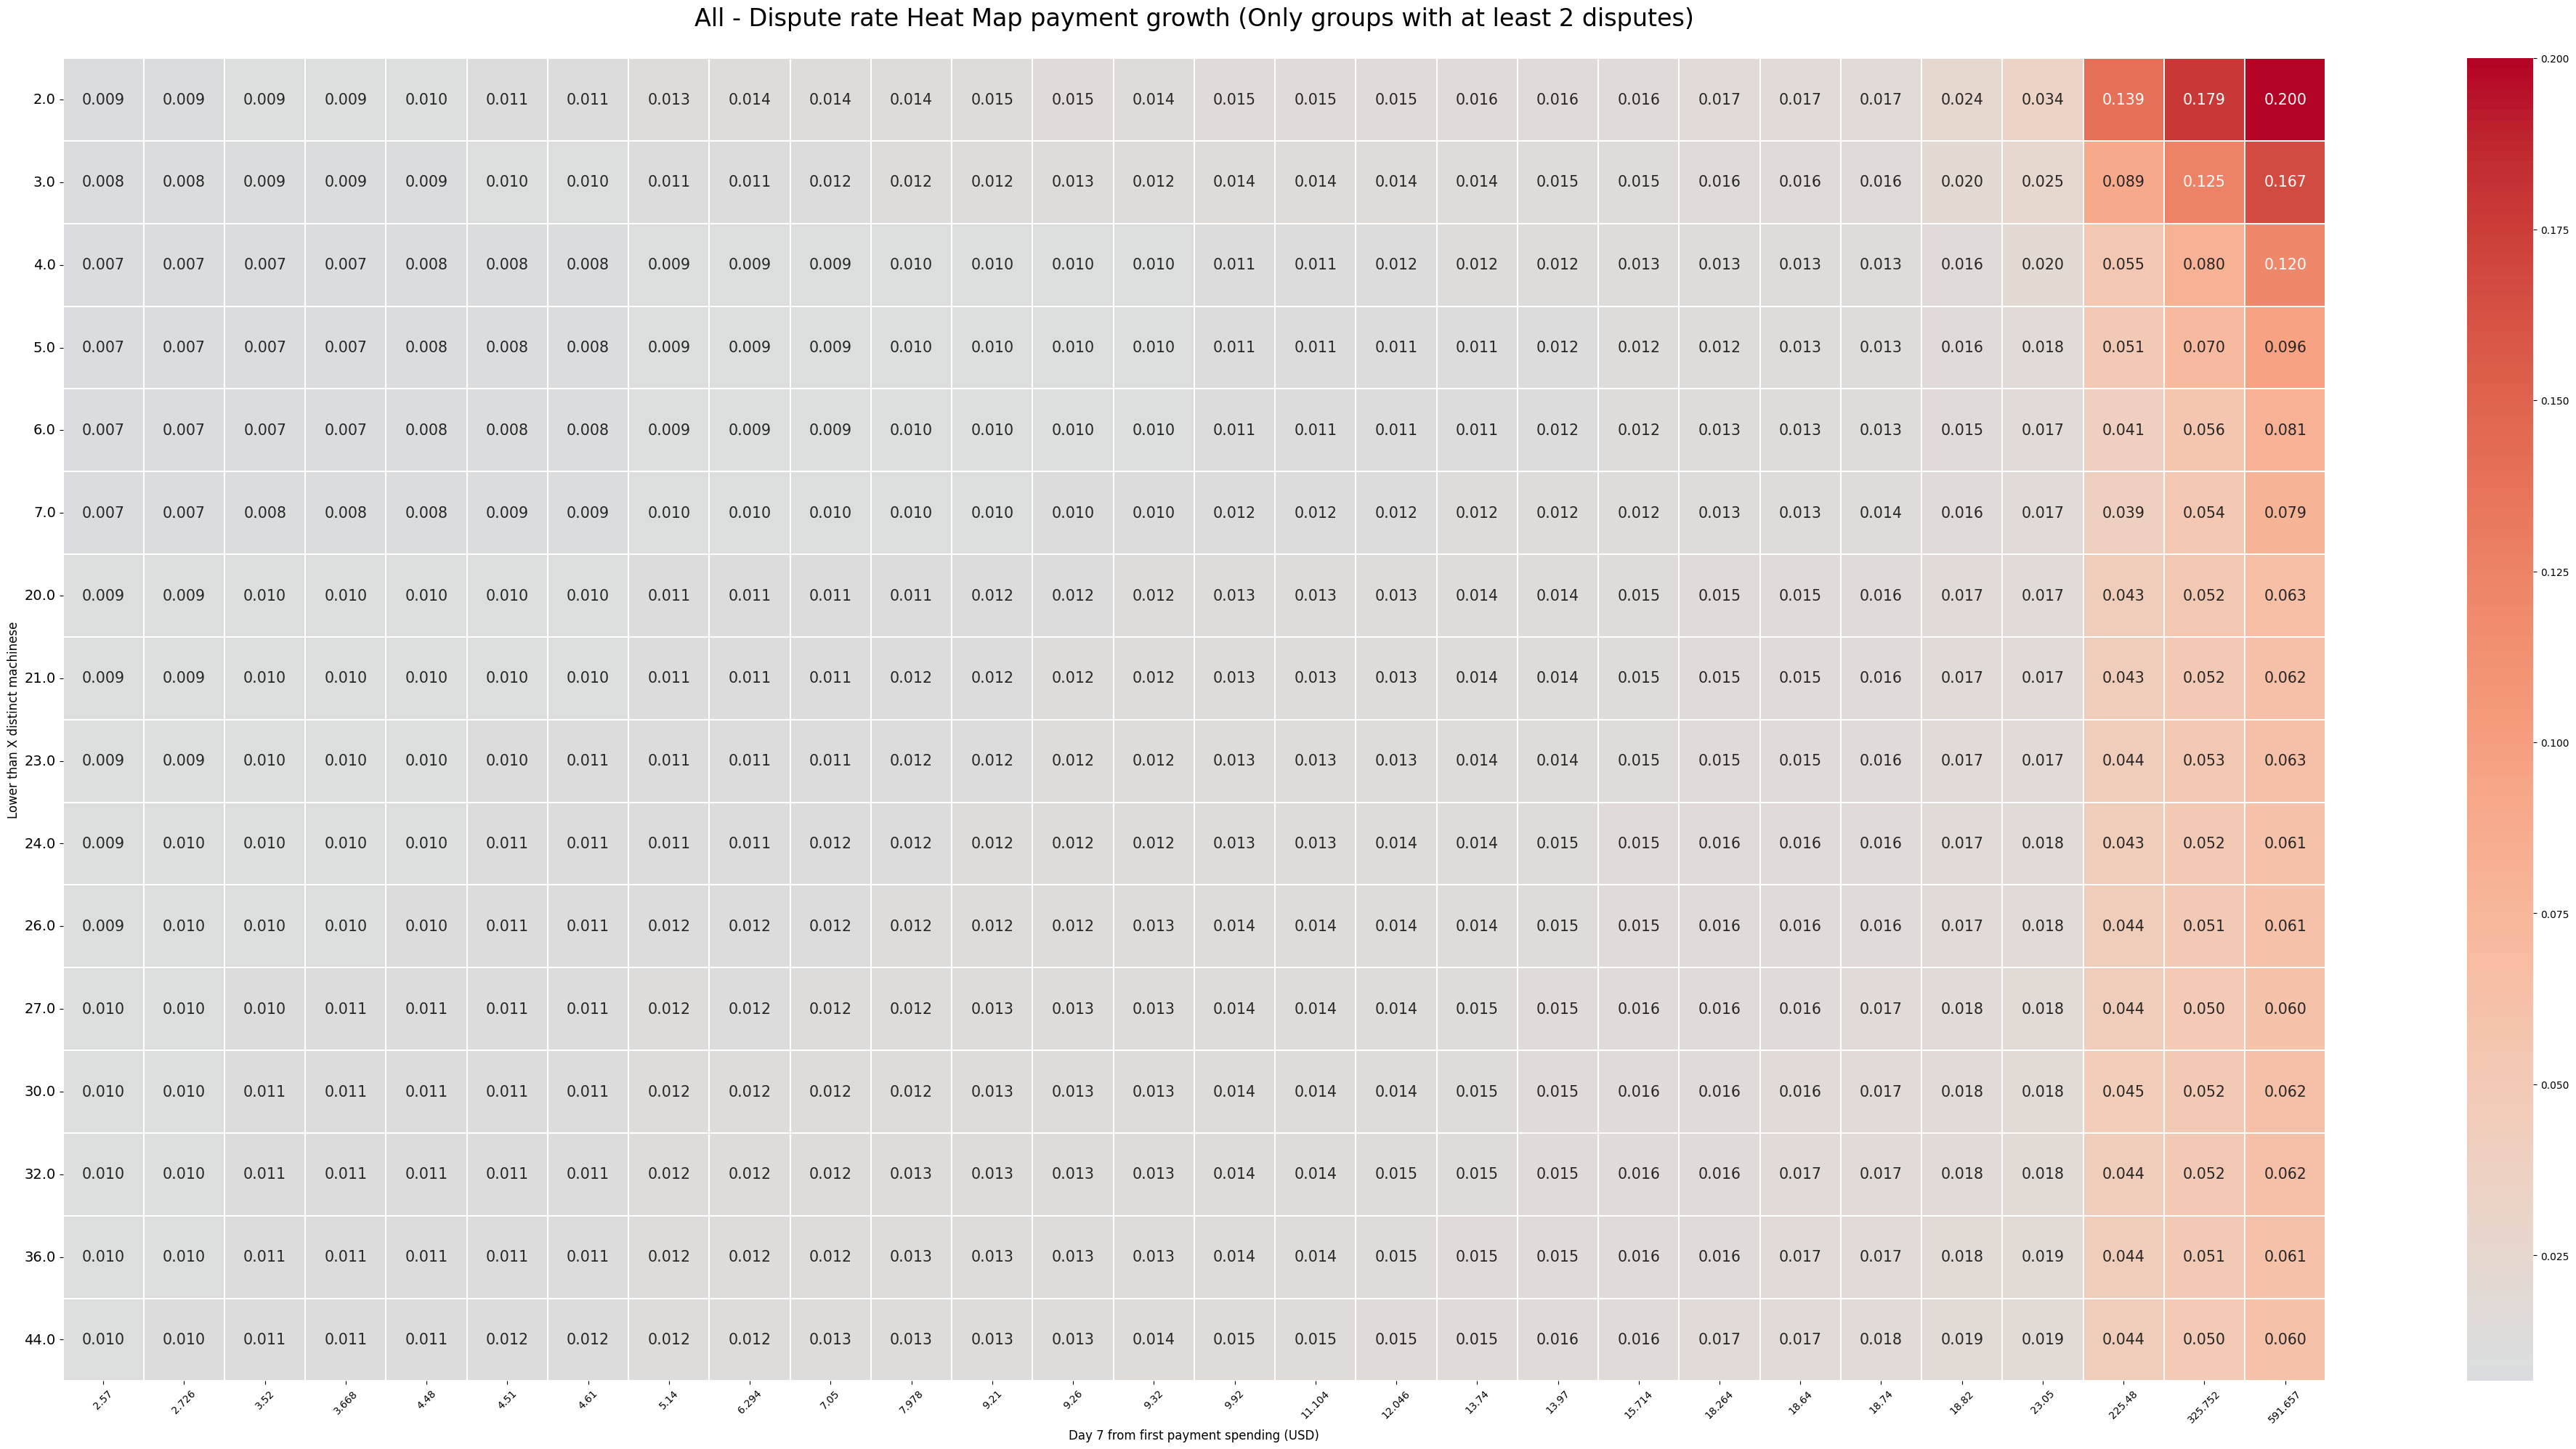

In [120]:
hola = compacted_df[compacted_df['Column_1'].str.endswith('_0.0')][compacted_df['Column_2'].str.endswith('_1.0')].sort_values(by = 'mean', ascending = False)#.head(12)
hola['C_1'] = hola['Column_1'] + ' - ' + compacted_df['Column_2']
hola = hola[hola['Column_2'].str.contains('mone', na=False)][hola['Column_1'].str.contains('ga', na=False)]
# hola['mean'] = hola['mean']*1.05

# hola = filtered_df[filtered_df['Column_1'].str.startswith('day') & filtered_df['Column_1'].str.endswith('1.0') & filtered_df['Column_2'].str.endswith('1.0')].sort_values(by=['d5_7', 'd2_4'])
# hola = hola[hola['d5_7'] >= 18][hola['d2_4'] >= 100]
# hola
# # Pivot the DataFrame to create a correlation matrix
hola['Column_2'] = hola['Column_2'].str.replace('monetary_consumption_score_gt_', '', regex=False)
hola['Column_2'] = hola['Column_2'].str.replace('_1.0', '', regex=False).astype(float)
hola['Column_1'] = hola['Column_1'].str.replace('game_types_gt_', '', regex=False)
hola['Column_1'] = hola['Column_1'].str.replace('.0_0', '', regex=False).str.replace('0_1', '', regex=False).astype(float)

hola = hola[hola['Column_2'] > 2]

hola = hola.sort_values(by = ['Column_1', 'Column_2'])
correlation_matrix = hola.pivot_table(index = 'Column_1', columns = 'Column_2', values = 'mean')

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(40, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".3f", linewidths=0.15, center=0.01, annot_kws={"fontsize": 14.8})
plt.title('All - Dispute rate Heat Map payment growth (Only groups with at least 2 disputes)', fontsize=24, y=1.02)
plt.yticks(rotation=0, fontsize=14)

plt.xlabel('Day 7 from first payment spending (USD)', fontsize=12, y=1.01)
# plt.ylabel('Day 5 to day 7 growth (x%)')
plt.ylabel('Lower than X distinct machinese', fontsize=12, x=1.01)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Tripple rule 

In [20]:
compacted_df.sort_values(by = 'mean', ascending = False).head(4)
filtered_next_step = compacted_df[compacted_df['sum'] >= 17][compacted_df['mean'] >= 0.079]
filtered_next_step['mean'].max()

0.12837837837837837

In [22]:
relevants_1 = list(set(list(filtered_next_step['Column_1'].str.replace(r'_1.0+$', '', regex=True).replace(r'_0.0+$', '', regex=True).unique())))
relevants_2 = list(set(list(filtered_next_step['Column_2'].str.replace(r'_1.0+$', '', regex=True).replace(r'_0.0+$', '', regex=True).unique())))

relevants_3_comb = list(set(relevants_1) | set(relevants_2))
print(len(relevants_3_comb))
# relevants_3_comb

116


In [240]:
# Save the cases 

# Create a set of combis_2 for quick lookup
combis = set(list(combis))

# Function to check if any pair in a tuple is in combis_2
def contains_combis_2_pair(triple, combis_2_set):
    pairs = list(itertools.combinations(triple, 2))
    return any(pair in combis_2_set for pair in pairs)

# Filter out combinations in combis that contain any pair from combis_2
combis_3 = list(itertools.combinations(relevants, 3))
combis_3 = [triple for triple in combis if not contains_combis_2_pair(triple, combis_2_set)]

NameError: name 'combis_2_set' is not defined

In [32]:
minimum_req

0.02

In [23]:
import itertools
import pandas as pd
from tqdm import tqdm

combis_3 = list(itertools.combinations(relevants_3_comb, 3))

# Extract the substrings before '_gt_' pattern from each tuple
prefixes = [[item.split('_gt_')[0] for item in pair] for pair in combis_3]

# Find the unique prefixes
unique_prefixes = set(prefix for sublist in prefixes for prefix in sublist)

# Initialize a list to store the filtered data
column_combinations = []

# Iterate over the data
for pair in combis_3:
    prefix1, prefix2, prefix3 = [item.split('_gt_')[0] for item in pair]
    # Check if the prefixes are different and all are in unique_prefixes
    if prefix1 in unique_prefixes and prefix2 in unique_prefixes and prefix3 in unique_prefixes and len({prefix1, prefix2, prefix3}) == 3:
        column_combinations.append(pair)

# Initialize an empty list to store filtered DataFrames
filtered_dfs = []

minimum_req = filtered_next_step['mean'].max()
minimum_req = 0.02
# Iterate over each combination (You can see how it looks before the processing and change this part)
for combination in tqdm(column_combinations):
    # Group by the current combination of columns
    grouped_1 = df.groupby(list(combination))['new_disputer_30d'].agg(['sum', 'count', 'mean']).reset_index()
    grouped_2 = df.groupby(list(combination))['disputed_d30'].agg(['sum']).reset_index()
    grouped_2.rename(columns={'sum': 'amount'}, inplace = True)
    grouped = pd.merge(grouped_1, grouped_2, on = combination)

    # Apply the filter condition
    filtered_grouped = grouped[(grouped['sum'] >= 10)][(grouped['mean'] >= 0.09)]
    # Append the filtered DataFrame to the list
    if not filtered_grouped.empty:
        filtered_dfs.append(filtered_grouped)

# filtered_dfs['amount'] = filtered_dfs['amount']
    

100%|██████████| 129434/129434 [43:37<00:00, 49.45it/s] 


In [1]:
    grouped_1 = df.groupby(list(combination))['new_disputer_30d'].agg(['sum', 'count', 'mean']).reset_index()
    grouped_2 = df.groupby(list(combination))['disputed_d30'].agg(['sum']).reset_index()
    grouped_2.rename(columns={'sum': 'amount'}, inplace=True)
    grouped = pd.merge(grouped_1, grouped_2, on=combination)
        if len(non_empty_columns) >= 2:
            # Add values to respective lists
            col1_values.append(non_empty_columns[0] + '_' + str(row[non_empty_columns[0]]))
            col2_values.append(non_empty_columns[1] + '_' + str(row[non_empty_columns[1]]))
            sum_values.append(row['sum'])
            count_values.append(row['count'])
            mean_values.append(row['mean'])
            amount_values.append(row['amount'])
            amount_per_values.append(row['amount_per'])
    
    # Create compacted DataFrame
    compacted_df = pd.DataFrame({'Column_1': col1_values ,
                                  'Column_2': col2_values,
                                  'sum': sum_values,
                                  'count': count_values,
                                  'mean': mean_values, 
                                  'amount': amount_values,
                                  'amount_per': amount_per_values})
    return compacted_df

IndentationError: unexpected indent (92442990.py, line 5)

In [35]:
del filtered_dfs

In [24]:
# Concatenate the filtered DataFrames (This takes a huge ammount of time)
result_df = pd.concat(filtered_dfs, ignore_index=True)

# Print the concatenated DataFrame
result_df.head(4)

,monetary_consumption_score_gt_183.451,long_sessions_ps_score_180_gt_18.0,payment_impulsiveness_score_gt_1.351,sum,count,mean,amount,long_sessions_ps_score_180_gt_35.0,game_types_gt_24.0,long_sessions_ps_score_180_gt_97.0,...,monetary_consumption_score_gt_107.73,long_sessions_ps_score_240_gt_6.0,monetary_consumption_score_gt_208.291,monetary_consumption_score_gt_243.044,monetary_consumption_score_gt_143.568,monetary_consumption_score_gt_161.412,long_sessions_ps_score_180_gt_11.0,long_sessions_ps_score_180_gt_10.0,long_sessions_ps_score_180_gt_12.0,long_sessions_ps_score_180_gt_7.0
0,1.0,1.0,1.0,22,219,0.100457,84799.73920,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,1.0,18,150,0.120000,76811.28920,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,16,175,0.091429,29163.24800,NaN,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,1.0,10,101,0.099010,61078.43088,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
result_df = result_df[result_df['mean'] >= 0.065]

In [28]:
result_df.columns = [col[:-5] if col.endswith('_true') else col for col in result_df.columns]
result_df['amount_per'] = (result_df['amount'] / disputed_amount).apply(lambda x: str(round(x*100, 2)) + '%')

In [29]:


def compact_dataframe(df):
    """
    Compact the DataFrame by keeping only two non-empty columns along with 'sum', 'count', and 'mean' columns.
    
    Parameters:
        df (DataFrame): The original DataFrame.
        
    Returns:
        DataFrame: The compacted DataFrame with two non-empty columns and 'sum', 'count', 'mean' columns.
    """
    # Initialize lists to store values for compacted DataFrame
    col1_values = []
    col2_values = []
    col3_values = []
    sum_values = []
    count_values = []
    mean_values = []
    amount_values = []
    amount_per_values = []
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Find the two non-empty columns (excluding 'sum', 'count', and 'mean')
        non_empty_columns = [col for col in row.index if col not in ['sum', 'count', 'mean', 'amount'] and pd.notnull(row[col])]
        # Ensure that at least two non-empty columns are found
  
        if len(non_empty_columns) >= 2:
            # Add values to respective lists
            col1_values.append(non_empty_columns[0] + '_' + str(row[non_empty_columns[0]]))
            col2_values.append(non_empty_columns[1] + '_' + str(row[non_empty_columns[1]]))
            col3_values.append(non_empty_columns[2] + '_' + str(row[non_empty_columns[2]]))
            sum_values.append(row['sum'])
            count_values.append(row['count'])
            mean_values.append(row['mean'])
            amount_values.append(row['amount'])
            amount_per_values.append(row['amount_per'])
    
    # Create compacted DataFrame
    compacted_df = pd.DataFrame({'Column_1': col1_values ,
                                  'Column_2': col2_values,
                                  'Column_3': col3_values,
                                  'sum': sum_values,
                                  'count': count_values,
                                  'mean': mean_values, 
                                  'amount': amount_values,
                                  'amount_per': amount_per_values})
    
    return compacted_df

# Example usage:
compacted_df = compact_dataframe(result_df)
compacted_df[compacted_df['sum'] >= 10].sort_values(by = 'mean', ascending = False).head(10)

,Column_1,Column_2,Column_3,sum,count,mean,amount,amount_per
13495,payment_impulsiveness_score_gt_42.944_1.0,long_sessions_ps_score_180_gt_57.0_1.0,game_types_gt_17.0_0.0,11,36,0.305556,15678.176,5.68%
3126,payment_impulsiveness_score_gt_42.944_1.0,long_sessions_ps_score_240_gt_56.0_1.0,game_types_gt_17.0_0.0,10,33,0.303030,15630.850,5.66%
13383,payment_impulsiveness_score_gt_42.944_1.0,long_sessions_ps_score_240_gt_49.0_1.0,game_types_gt_17.0_0.0,11,39,0.282051,15678.176,5.68%
8991,payment_impulsiveness_score_gt_5.272_1.0,long_sessions_ps_score_180_gt_57.0_1.0,game_types_gt_17.0_0.0,12,43,0.279070,17294.676,6.26%
1543,payment_impulsiveness_score_gt_42.944_1.0,long_sessions_ps_score_240_gt_56.0_1.0,game_types_gt_18.0_0.0,10,36,0.277778,15630.850,5.66%
8561,payment_impulsiveness_score_gt_42.944_1.0,long_sessions_ps_score_180_gt_51.0_1.0,game_types_gt_17.0_0.0,11,41,0.268293,15678.176,5.68%
2910,long_sessions_ps_score_240_gt_56.0_1.0,payment_impulsiveness_score_gt_5.272_1.0,game_types_gt_17.0_0.0,10,38,0.263158,15630.850,5.66%
1859,payment_impulsiveness_score_gt_42.944_1.0,long_sessions_ps_score_180_gt_57.0_1.0,game_types_gt_18.0_0.0,11,42,0.261905,15678.176,5.68%
11574,payment_impulsiveness_score_gt_4.656_1.0,long_sessions_ps_score_180_gt_57.0_1.0,game_types_gt_17.0_0.0,12,46,0.260870,17294.676,6.26%
1846,payment_impulsiveness_score_gt_42.944_1.0,long_sessions_ps_score_240_gt_49.0_1.0,game_types_gt_18.0_0.0,11,45,0.244444,15678.176,5.68%


In [31]:
compacted_df[compacted_df['sum'] >= 47].sort_values(by = 'mean', ascending = False).head(20)

,Column_1,Column_2,Column_3,sum,count,mean,amount,amount_per
4254,long_sessions_ps_score_240_gt_30.0_1.0,monetary_consumption_score_gt_1114.575_1.0,game_types_gt_28.0_0.0,58,539,0.107607,121838.78076,44.12%
4252,long_sessions_ps_score_240_gt_28.0_1.0,monetary_consumption_score_gt_1114.575_1.0,game_types_gt_28.0_0.0,59,552,0.106884,123058.09076,44.56%
4236,long_sessions_ps_score_240_gt_32.0_1.0,monetary_consumption_score_gt_1114.575_1.0,game_types_gt_28.0_0.0,54,511,0.105675,118057.18876,42.75%
4206,long_sessions_ps_score_180_gt_33.0_1.0,monetary_consumption_score_gt_1114.575_1.0,game_types_gt_28.0_0.0,58,550,0.105455,122681.69076,44.42%
4919,long_sessions_ps_score_240_gt_30.0_1.0,monetary_consumption_score_gt_1114.575_1.0,game_types_gt_29.0_0.0,59,562,0.104982,130413.51792,47.22%
5510,long_sessions_ps_score_240_gt_30.0_1.0,monetary_consumption_score_gt_1114.575_1.0,game_types_gt_27.0_0.0,54,515,0.104854,112681.07076,40.8%
4917,long_sessions_ps_score_240_gt_28.0_1.0,monetary_consumption_score_gt_1114.575_1.0,game_types_gt_29.0_0.0,60,576,0.104167,131632.82792,47.66%
5508,long_sessions_ps_score_240_gt_28.0_1.0,monetary_consumption_score_gt_1114.575_1.0,game_types_gt_27.0_0.0,55,528,0.104167,113900.38076,41.24%
4239,long_sessions_ps_score_240_gt_27.0_1.0,monetary_consumption_score_gt_1114.575_1.0,game_types_gt_28.0_0.0,60,577,0.103986,124258.72908,44.99%
5692,long_sessions_ps_score_240_gt_30.0_1.0,monetary_consumption_score_gt_1114.575_1.0,game_types_gt_25.0_0.0,47,453,0.103753,107852.66876,39.05%


In [ ]:
# osses_of_winning_score_gt_0.12_0.0	increasing_tolerance_gt_2.3_1.0	long_sessions_ps_score_180_gt_0.82_1.0	10.0	116.0	0.086207

In [709]:
compacted_df['prob_score'] = (compacted_df['mean'] / df['new_disputer_30d'].mean()).apply(lambda x: str(round(x*100)) + '%')
compacted_df[compacted_df['sum'] >= 40].sort_values(by = 'mean', ascending = False).head(10)

,Column_1,Column_2,Column_3,sum,count,mean,prob_score
156094,monetary_consumption_score_gt_1114.575_1.0,payment_methods_score_gt_2.0_1.0,long_sessions_ps_score_240_gt_30.0_1.0,44.0,399.0,0.110276,1173%
157250,monetary_consumption_score_gt_1114.575_1.0,payment_methods_score_gt_2.0_1.0,long_sessions_ps_score_240_gt_28.0_1.0,44.0,405.0,0.108642,1156%
164215,monetary_consumption_score_gt_1114.575_1.0,payment_methods_score_gt_2.0_1.0,long_sessions_ps_score_240_gt_27.0_1.0,45.0,416.0,0.108173,1151%
164454,monetary_consumption_score_gt_1114.575_1.0,payment_methods_score_gt_2.0_1.0,payment_impulsiveness_score_gt_21.073_1.0,43.0,400.0,0.107500,1144%
70775,long_sessions_ps_score_180_gt_31.0_1.0,monetary_consumption_score_gt_1114.575_1.0,payment_methods_score_gt_2.0_1.0,44.0,411.0,0.107056,1139%
160080,monetary_consumption_score_gt_1114.575_1.0,payment_methods_score_gt_2.0_1.0,long_sessions_ps_score_240_gt_25.0_1.0,45.0,422.0,0.106635,1135%
163704,monetary_consumption_score_gt_1114.575_1.0,payment_impulsiveness_score_gt_16.913_1.0,payment_methods_score_gt_2.0_1.0,42.0,395.0,0.106329,1131%
159590,monetary_consumption_score_gt_1114.575_1.0,payment_methods_score_gt_2.0_1.0,long_sessions_ps_score_240_gt_32.0_1.0,41.0,386.0,0.106218,1130%
162977,monetary_consumption_score_gt_1114.575_1.0,payment_impulsiveness_score_gt_0.942_1.0,payment_methods_score_gt_2.0_1.0,43.0,405.0,0.106173,1130%
164469,monetary_consumption_score_gt_1114.575_1.0,payment_methods_score_gt_2.0_1.0,long_sessions_ps_score_180_gt_33.0_1.0,43.0,406.0,0.105911,1127%


In [259]:
df['new_disputer_30d'].mean()

0.003568473314025652